## Author : Si-Dan HO

# Pricing d'options sur S&P500 dans un modèle à volatilité stochastique log-normale

In [3]:
import time
import datetime as dt
import pandas as pd
import numpy as np
import math
import scipy.stats as sps
import scipy as sp
import scipy.optimize as spop
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm 
import pylab as py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from tqdm import tqdm_notebook as tq
import random

# Sommaire

- Introduction
- Pricing Monte Carlo des options sur S&P500 sous le modèle de Bergomi à deux facteurs
    - Réduction de la variance par la méthode de variables antithétiques
- Calcul et traçage des volatilités implicites sous le modèle de Bergomi à deux facteurs pour les options sur S&P500
- Calibration du modèle de Bergomi à deux facteurs pour les options sur S&P500
    - Définition et pricing des Variance Swap sur S&P500
        - Chargement des données contenant le prix des options sur SPX
        - Valorisation des swaps de variance sur S&P500 à partir des données
        - Calcul du prix forward $F$ de l'indice du S&P500 pour chaque maturité
        - Jointure des données et calcul du prix des Variance Swaps
    - Pricing des Variance Swaps sur S&P500 sous un modèle GARCH
        - Chargement des données historiques sur S&P500 et test statistiques sur série temporelle
        - Modélisation de la volatilité historique sur S&P500 par un modèle GARCH(1,1)
    - Paramétrisation de la variance forward instantanée initiale $\xi_0^t$
        - Calibration via la volatilité instantanée de la volatilité d'un Variance Swaps
            - Expression de la volatilité de la volatilité du Variance Swap sous le modèle GARCH
    - Expression du Skew At the Money Forward ATMF à maturité $T$ sous le modèle de Bergomi à deux facteurs
    - Calibration d'une surface de volatilité implicite de type SVI
        - Expression du Skew At the Money Forward ATMF à partir des surfaces de volatilité implicites SVI par maturité $T$
    - Utilisation de données alternatives provenant de la cotation du 16 Avril 2016
    - Méthode retenue pour la calibration des paramètres $\Theta = \{\omega, \gamma, k_1, k_2, \rho_1, \rho_2, \rho_{12} \}$
    - Vérification de la qualité de la calibration

# Introduction

On considère un modèle à volatilité stochastique pour un actif $S$, défini sur un espace de probabilité $(\Omega, \mathcal{F}, (\mathcal{F})_{t \geq 0}), \mathbb{P})$ équipé avec un mouvement Brownien standard $(W_t^1, W_t^2)_{t \geq 0}$ dont la corrélation entre ces deux quantités est de $\rho_{12} \in [0,1]$ et d'un deuxième mouvement brownien $(B_t)_{t \geq 0}$ tel que : $<W^1, B>_t = \rho_1 t$ et $<W^2, B>_t = \rho_2 t$, pour $\rho_1, \rho_2 \in [0,1]$.

Plus particulièrement, le modèle considéré est ici est celui à volatilité stochastique log-normale, où la dynamique de l'actif $S$ est la suivante, sous la probabilité risque neutre :

$$
dS_t = S_t(rdt + \sigma_t dB_t), \ t \geq 0
$$

où : $\sigma_t = \sqrt{\xi_t^t},  \ t \geq 0$, adapté à $(\mathcal{F}_t)_t$ et de carré intégrable.


La brique de base du modèle est, comme dans le projet précédent, un modèle pour la variance forward de $S$ : pour tout $T > 0$, le processus de variance forward instantané $(\xi_t^T)_{t < T}$ est la solution de l'équation différentielle stochastique de Dupire :

$$
d\xi_t^T = \xi_t^T \varphi(T-t) dW_t^1, \ t < T \\
\xi_0^T = \xi_0^{T, mkt}
$$

avec $\varphi \in L^2_{loc}(\mathbb{R}_{+})$ une fonction de carré intégrable, et $T \rightarrow \xi_0^{T, mkt}$ la courbe de variance forward instantanée initiale donnée par le marché en $t=0$.

Comme démontré précédemment, l'équation différentielle stochastique de Dupire admet la solution explicie suivante :

$$
\xi_t^T = \xi_0^Te^{\int_{0}^{t} \varphi (T-s) dW_s^1 - \frac{1}{2} \int_{0}^{t} \varphi^2 (T-s) ds}, \forall t \leq T
$$

Finalement, le modèle à volatilité stochastique log-normale est cohérent avec celui de Dupire pour $\xi$, dans le sens où la variance forward $V_t^{T_1, T_2}$ de l'actif $S$ coincide bien avec $\frac{1}{T_2 - T_1} \int_{T_1}^{T_2} \xi_t^{u}du$ pour tout $t \leq T_1 < T_2$.

Grâce à l'expression explicite pour le processus $\xi_t^T$, le processus de volatilité instantanée
$\sigma_t$ peut être simulé exactement : la loi de la trajectoire $(\sigma_{t_1}, ..., \sigma_{t_n})$ est connue pour
toute famille d'instants $(t_i)_{i=1,...,n}$. En effet :

$$
\xi_t^T = \xi_0^Te^{\int_{0}^{t} \varphi (T-s) dW_s^1 - \frac{1}{2} \int_{0}^{t} \varphi^2 (T-s) ds}, \ \forall t \leq T
$$

et il a été démontré dans le projet précédent que : $\int_{0}^{\tau} \varphi (u-s) dW_s^1 = \varphi (u-\tau) X_{\tau}$ où où $(X_t)$ est un processus d'Ornstein-Uhlenbeck dont la condition initiale est $X_0 = 0$ et la dynamique est donnée par $dX_t = -kX_tdt + dW_t^1$.

Ainsi, il est une fois de plus clair que $(X_t)$ est un processus Gaussien pouvant être simulé, d'espérance, de variance et de covariance respectives :

- $\mathbb{E}[X_t] = 0$
- $Var[X_t] = h(t) = \frac{1}{2k}(1-e^{-2kt})$
- $Cov[X_s,X_t] = \frac{1}{2k}e^{-k(s+t)}(e^{-2k s \wedge t}-1)$

De ce fait, la variance instantanée est exprimée comme suit :

$$
\xi_t^t = \xi_0^te^{\int_{0}^{t} \varphi (t-s) dW_s - \frac{1}{2} \int_{0}^{t} \varphi^2 (t-s) ds} = \xi_0^te^{\varphi (0) X_{t} - \frac{1}{2}\varphi^2 (0)Var[X_t]}
$$

ce qui permet d'obtenir l'expression de la volatilité instantanée $\sigma_t = \sqrt{\xi_t^t}$.

Si la volatilité instantanée est directement simulable à partir du processus d'Ornstein Uhlenbeck $X_t$, il n'en est rien de l'actif $S_t$. Pour ce faire, la trajectoire de la volatilité instantanée $(\sigma_{t_0}, ..., \sigma_{t_n})$ est dans un premier temps simulée sur une grille $(t_i)_{i=0,...,n}$, ce qui permet d'obtenir la trajectoire de l'actif $S_t$ sur cette même grille : $(S_{t_0}, ..., S_{t_n})$, à partir d'un Schéma d'Euler appliqué au processus $log(S_t/S_0)$.

En effet, sachant que : 

$$
dS_t = S_t(rdt + \sigma_t dB_t), \ t \geq 0
$$

Alors en appliquant la formule d'Itô sur $y_t = log(S_t/S_0)$, la dynamique de celle ci est donnée par :

$$
dy_t = (r - \frac{1}{2}\sigma_t)dt + \sigma_t dB_t \\
y_0 = 0
$$


Ainsi, le système d'équation différentielle stochastique concernant la volatilité instantanée $\xi$ et de l'actif $S$ est:

$$
\left\{
    \begin{array}{lll}
    \sigma_t = \sqrt{\xi_0^te^{\varphi (0) X_{t} - \frac{1}{2}\varphi^2 (0)Var[X_t]}} \\
    dy_t = (r - \frac{1}{2}\sigma_t)dt + \sigma_t dB_t, \ x_0 = 0 \\
    <B, X>_t = <B, W^1>_t =  \rho_1 t
    \end{array}
\right.
$$

De ce fait, le système peut donc être simulé en discrétisant l'espace temps $[0,T]$, $T$ étant la maturité de l'option, en $N+1$ dates $t_0=0, ..., t_N=T$ avec $t_i = i\Delta$, permettant ainsi d'obtenir $N$ intervalles de temps $dt = \Delta = \frac{T}{N}$. 

Ainsi, les deux équations peuvent être discrétisées par la méthode d'Euler, en notant que les mouvements browniens $dB_t$ et $dW_t^1$  suivent respectivement les loi normale $\mathcal{N}(0,dt)$, que $X_t$ a pour dynamique $dX_t = -kX_tdt + dW_t^1$, et en prenant en compte la corrélation de ces deux quantités via la transformation de Cholesky:

$$
\left\{
    \begin{array}{llll}
    X_{t_i} =  X_{t_{i-1}}-kX_{t_{i-1}}\Delta + \sqrt{\Delta} \epsilon_1, \ X_0 = 0 \\
    \xi_{t_i}^{T=t_i} = \xi_0^{T=t_i}e^{\varphi(0) X_{t_i} - \frac{1}{2}\varphi^2 (0)\mathbb{E}[X_{t_i}^2]} \\
    y_{t_{i+1}}  - y_{t_i} = (r - \frac{1}{2}\xi_{t_i}^{T=t_i})\Delta + \sqrt{\xi_{t_i}^{T=t_i} \Delta} \epsilon_2, \ y_0 = 0 \\
    \epsilon_2 = \rho_1 \epsilon_1 + \sqrt{1-\rho_1^2} \epsilon
    \end{array}
\right.
$$

pour tout $i \in 1,...,N$, avec $\epsilon$ suivant une loi normale centrée réduite indépendante de $\epsilon_1$ et $\epsilon_2$, qui suivent aussi la même loi. Il convient de rappeler que $Cov(\epsilon_1, \epsilon_2) = \rho_1$.

Sachant que la trajectoires $(y_{t_0}, ..., y_{t_n})$ de $log(S_t/S_0)$ peut être explicitement obtenu grâce à ce Schéma d'Euler, celle de l'actif $S$ qui est $(S_{t_0}, ..., S_{t_n})$ peut ainsi être obtenu en appliquant : $S_{t_i} = S_0e^{y_{t_i}}$.

D'après le théorème fondamental de la valorisation des actifs, le prix du Call de strike $K$, de maturité $T$, dont le sous jacent est l'actif $S$, et dont le pay-off est donc $(S_T - K)_{+}$, peut s'écrire sous forme d'espérance risque-neutre conditionnelle de ses flux futurs actualisés :

$$
C_t = c(t, S, \sigma) = e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}[(S_T - K)_{+}|S_t = S]
$$

Plus particulièrement, le prix actuel du Call sur l'actif S est donné par :

$$
C_0 = c(0, S, \sigma) = e^{-rT}\mathbb{E}^{\mathbb{Q}}[(S_T - K)_{+}|S_0 = S_0]
$$

Cette forme sous espérance du prix du Call permet ainsi sa valorisation par application de la méthode Monte Carlo. De ce fait, pourvu que le nombre de simulations $M$ soit suffisamment grande pour la convergence de l'estimateur, l'expression ci-dessus peut être estimée par :

$$
\hat{C}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M}(S_T^i - K)_{+}
$$

L'estimation du prix d'un Put sur l'actif $S$ peut être effectuée de manière similaire en sachant que son payoff est cette fois ci égale à $(K - S_T)_{+}$.

La valorisation ne sera pas implémentée pour ce modèle puisque celui ci possède des limites qui peuvent être compensées par le modèle de Bergomi à deux facteurs, qui est introduite dans le paragraphe ci dessous, et dont une implémentation sera effectuée pour la valorisation Monte Carlo sous ce modèle :

## Pricing Monte Carlo des options sur S&P500 sous le modèle de Bergomi à deux facteurs

Plus particulièrement, le modèle de Bergomi à deux facteurs permet de spécifier de la manière suivante la dynamique de la variance forward d'un actif $S$ que l'on suppose être l'indice du S&P500 (dans l'énoncé du projet, il y a deux paramètres $\omega_1$ et $\omega_2$, cependant, dans un des articles rédigés par M. Lorenzo Bergomi, il n'utilise qu'un unique paramètre $\omega$ :

$$
d\xi_t^T = \omega \alpha_{\gamma} \xi_t^T [(1-\gamma)e^{-k_1 (T-t)}dW_t^1 + \gamma e^{-k_2 (T-t)}dW_t^2] \\
\xi_0^T = \xi_0^{T, mkt}
$$

avec $T \rightarrow \xi_0^{T, mkt}$ la courbe de variance forward instantanée initiale donnée par le marché en $t=0$ et $\alpha_{\gamma} = 1/\sqrt{(1-\gamma)^2 + \gamma^2 + 2\rho_{12}\gamma(1-\gamma)}$ le facteur de normalisation.

En se rappelant qu'entre autres, $\int_{0}^{\tau} \varphi (u-s) dW_s^1 = \varphi (u-\tau) X_{\tau}$ où où $(X_t)$ est un processus d'Ornstein-Uhlenbeck dont la condition initiale est $X_0 = 0$ et la dynamique est donnée par $dX_t = -k_1X_tdt + dW_t^1$. La solution de l'équation différentielle stochastique précédente est donc donnée par :

$$
\xi_t^T = \xi_0^T exp((1-\gamma)(\omega \alpha_{\gamma} e^{-k_1(T-t)}X_t - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_1(T-t)} \mathbb{E}[X_t^2]) + \gamma (\omega \alpha_{\gamma} e^{-k_2(T-t)}Y_t - \frac{(\omega \alpha_{\gamma})^2}{2} e^{-2k_2(T-t)} \mathbb{E}[Y_t^2]) - (\omega \alpha_{\gamma})^2 \gamma(1-\gamma)e^{-(k_1+k_2)(T-t)}\mathbb{E}[X_t Y_t]), \forall t \leq T
$$

C'est à dire :

$$
\xi_t^T = \xi_0^T exp(\omega \alpha_{\gamma} [(1-\gamma)e^{-k_1(T-t)}X_t + \gamma e^{-k_2(T-t)}Y_t] - \frac{(\omega \alpha_{\gamma})^2}{2} [(1-\gamma)e^{-2k_1(T-t)} \mathbb{E}[X_t^2]  + \gamma e^{-2k_2(T-t)} \mathbb{E}[Y_t^2] + 2\gamma(1-\gamma)e^{-(k_1+k_2)(T-t)}\mathbb{E}[X_t Y_t]]), \forall t \leq T
$$

Avec $X_t$ et $Y_t$ des processus d'Ornstein Uhlenbeck de condition initiale égale à 0 et de dynamique respectives : $dX_t = k_1X_t + dW_t^1$ et $dY_t = k_2 Y_t + dW_t^2$.

Les trois espérances, qui sont la variance et la covariance des processus $X_t$ et $Y_t$, sont respectivement égales à :

- $\mathbb{E}[X_t^2] = \frac{1- e^{-2k_1t}}{2k_1}$
- $\mathbb{E}[Y_t^2]= \frac{1- e^{-2k_2t}}{2k_2}$
- $\mathbb{E}[X_t Y_t]= \rho_{12}\frac{1- e^{-(k_1+k_2)t}}{k_1+k_2}$

Ainsi, le pricing Monte Carlo d'une option sur SPX peut se résumer comme suit :

Pour i allant de 1 à $M$ suffisamment grand, on applique le Schéma d'Euler sur le système d'équation différentielle stochastique de manière suivante,en discrétisant l'espace temps $[0,T]$, $T$ étant la maturité de l'option, en $N+1$ dates $t_0=0, ..., t_N=T$ avec $t_i = i\Delta$, permettant ainsi d'obtenir $N$ intervalles de temps $dt = \Delta = \frac{T}{N}$ :

$$
\left\{
    \begin{array}{lll}
    X_{t_i} - X_{t_{i-1}} =-k_1X_{t_{i-1}}\Delta + \sqrt{\Delta} \epsilon_1, \ X_0 = 0 \\
    Y_{t_i} -  X_{t_{i-1}} = -k_2Y_{t_{i-1}}\Delta + \sqrt{\Delta} \epsilon_2, \ Y_0 = 0 \\
    \epsilon_2 = \rho_{12} \epsilon_1 + \sqrt{1-\rho_{12}^2} \epsilon
    \end{array}
\right.
$$

pour tout $i \in 1,...,N$, avec $\epsilon$ suivant une loi normale centrée réduite indépendante de $\epsilon_1$ et $\epsilon_2$, qui suivent aussi la même loi.

De ce fait, il convient de calculer $\xi_{t_i}^{t_i}$ grâce à l'expression du processus de variance forward instantanée $\xi_t^T$ établie précédemment.

Enfin, sachant que les corrélations entre les deux mouvements browniens $W_t^1$ et $W_t^2$ caractérisant la dynamique de $X_t$ et $Y_t$ et $B_t$ sont respectivement égales à $\rho_1$ et $\rho_2$, on génère une variable aléatoire centrée réduite $\epsilon_3$ telle que selon la transformation de Cholesky :

$$
\epsilon_3 = \frac{\rho_1 - \rho_{12}\rho_2}{1 - \rho_{12}^2}\epsilon_1 + \frac{\rho_1 - \rho_{12}\rho_2}{1 - \rho_{12}^2}\epsilon + \sqrt{1-\lambda^2}\epsilon_{bis}
$$

avec $\lambda^2 = \frac{\rho_1^2 + \rho_2^2 - 2\rho_{12}\rho_1 \rho_2}{1 - \rho_{12}^2}$, et $\epsilon_{bis}$ une variable gaussienne centrée réduite indépendante de $\epsilon_1$ et $\epsilon$.

Ce qui permet enfin d'appliquer le schéma d'Euler pour obtenir la trajectoire du processus $y_t = log(S_t/S_0)$ :

$$
y_{t_i} - y_{t_{i-1}}  = (r - \frac{1}{2}\xi_{t_{i-1}}^{t_{i-1}})\Delta + \sqrt{\xi_{t_{i-1}}^{t_{i-1}} \Delta} \epsilon_3, \ y_0 = 0
$$

Finalement, la trajectoire de l'actif $S$ : $(S_{t_0}, ..., S_{t_n})$ est obtenu en appliquant : $S_{t_i} = S_0e^{y_{t_i}}$.

Cela permet ainsi d'estimer par Monte Carlo le prix actuel d'un Call et d'un Put sur le S&P500 selon le modèle de Bergomi à deux facteurs:

$$
\hat{C}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M}(S_T^i - K)_{+} \\
\hat{P}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M}(K- S_T^i)_{+}
$$

### Réduction de la variance par la méthode des variables antithétiques

Cependant, afin de stabiliser la variance des estimateurs Monte Carlo, il a été convenu d'appliquer la méthode des variables antithétiques, dont les explications ont été faites dans l'autre projet concernant le modèle de Bergomi où il a fallu valoriser les options sur VIX. De ce fait, sous cette méthode, sachant que le système d'équation différentielles initial à simuler est donné par :

$$
\left\{
    \begin{array}{lll}
    X_{t_i} - X_{t_{i-1}} =-k_1X_{t_{i-1}}\Delta + \sqrt{\Delta} \epsilon_1, \ X_0 = 0 \\
    Y_{t_i} -  X_{t_{i-1}} = -k_2Y_{t_{i-1}}\Delta + \sqrt{\Delta} \epsilon_2, \ Y_0 = 0 \\
    \epsilon_2 = \rho_{12} \epsilon_1 + \sqrt{1-\rho_{12}^2} \epsilon
    \end{array}
\right.
$$

Il convient de considérer les opposés des variables normales centrées réduites déjà simulées c'est à dire $-\epsilon$, $-\epsilon_1$ et ainsi $-\epsilon_2 = -\rho_{12} \epsilon_1 + -\sqrt{1-\rho_{12}^2} \epsilon$, en sachant que l'opposé d'une variable gaussienne est de même loi que celle ci, pour construire additionnellement les variables antithétiques $(X_t^{'})$ et $(Y_t^{'})$ selon le système d'équation différentielle discrétisé suivant :

$$
\left\{
    \begin{array}{lll}
    X_{t_i}^{'} - X_{t_{i-1}}^{'}  =-k_1X_{t_{i-1}}^{'} \Delta - \sqrt{\Delta} \epsilon_1, \ X_0 = 0 \\
    Y_{t_i}^{'}  -  X_{t_{i-1}}^{'}  = -k_2Y_{t_{i-1}}^{'} \Delta - \sqrt{\Delta} \epsilon_2, \ Y_0 = 0 \\
    -\epsilon_2 = -\rho_{12} \epsilon_1 - \sqrt{1-\rho_{12}^2} \epsilon
    \end{array}
\right.
$$

En calculant $\xi_{t_i}^{t_i'}$ à partir de la formule appropriée et des nouveaux processus $(X_t^{'})$ et $(Y_t^{'})$ et considérant par ailleurs la variable $-\epsilon_3$, opposé de $\epsilon_3$ et en appliquant du schéma d'Euler pour obtenir la trajectoire du processus $y_t^{'} = log(S_t^{'}/S_0)$, opposé de $y_t = log(S_t/S_0)$, nous obtenons :

$$
y_{t_{i}}^{'} - y_{t_{i-1}}^{'}  = (r - \frac{1}{2}\xi_{t_{i-1}}^{t_{i-1}'})\Delta - \sqrt{\xi_{t_{i-1}}^{t_{i-1}'} \Delta} \epsilon_3, \ y_0 = 0
$$

ce qui permet d'obtenir la trajectoire antithétique de l'actif $S$ : $(S_{t_0}^{'}, ..., S_{t_n}^{'})$ en appliquant : $S_{t_i}^{'} = S_0e^{y_{t_i}^{'}}$

Et les estimateurs Monte Carlo par variables antithétiques du prix actuel d'un Call et d'un Put sur le S&P500 selon le modèle de Bergomi à deux facteurs sont données par:

$$
\tilde{C}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M} \frac{(S_T^i - K)_{+} + (S_T^{i'} - K)_{+}}{2} \\
\tilde{P}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M} \frac{(K- S_T^i)_{+} + (K- S_T^{i'})_{+}}{2}
$$

Par ailleurs, la courbe de variance forward instantanée initiale $\xi_0^t$ doit être définie préalablement avant la valorisation pour chaque instant $t$. Ce point sera traité en détail dans les parties à venir, mais une brève explication sera effectuée étant donnée que cela est nécessaire pour l'application du pricing Monte Carlo. Cette quantité est la dérivée de $(\hat{\sigma}_0^t)^2t$ avec $\hat{\sigma}_0^t$ le juste prix d'un Swap de Variance sur S&P500. Celle ci peut être paramétrisée selon un schéma mean-reverting, lui permettant d'obtenir comme expression :

$$
\hat{\sigma}_0^t = z_2 + (z_1 - z_2)e^{-z_3t}
$$

Et les paramètres seront choisis tels que $z_1 = 12.03\%$, $z_2 = 21.80\%$ et $z_3 = 2.166$. 

De ce fait, la variance forward instantanée initiale est telle que :

$$
\xi_0^t = (z_2 + (z_1-z_2)e^{-z_3t})^2 -2tz_3(z_1-z_2)e^{-z_3t}(z_2 + (z_1-z_2)e^{-z_3t})
$$

Ce qui la permet, ainsi que l'estimateur Monte Carlo dans le cas d'un Call d'être implémentée comme suit :

In [4]:
def ForwardVarInitial(t):
    z1 = 12.03/100
    z2 = 21.80/100
    z3 = 2.166
    return (z2 + (z1-z2)*math.exp(-z3*t))**2 - 2*t*z3*(z1-z2)*math.exp(-z3*t)*(z2 + (z1-z2)*math.exp(-z3*t))

# n : nombre de simulations nécessaire pour construire une trajectoire de 0 à T pour S et sigma
# M : nombre de trajectoires à simuler pour calculer le prix du Call par Monte Carlo

def fast_MC_2FactorsBergomi_Call(S0,omega,gamma,k1,k2,rho1,rho2,rho12,r,T,K,n,M):
    # On discrétise l'espace de temps
    Delta_t = T/n
    
    # On définit le facteur de normalisation
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    
    # On initialise la somme Monte Carlo
    G = 0
    
    # On initialise les trajectoires des variables X, Y et y
    Traj_X = np.zeros((M,n+1))
    Traj_X[:,0] = np.array([0 for i in range(M)])
    
    Traj_Y = np.zeros((M,n+1))
    Traj_Y[:,0] = np.array([0 for i in range(M)])

    Traj_y = np.zeros((M,n+1))
    Traj_y[:,0] = np.array([0 for i in range(M)])
    
    # On initialise les trajectoires de leur variables antithétiques
    Traj_X_Anti = np.zeros((M,n+1))
    Traj_X_Anti[:,0] = np.array([0 for i in range(M)])
    
    Traj_Y_Anti = np.zeros((M,n+1))
    Traj_Y_Anti[:,0] = np.array([0 for i in range(M)])

    Traj_y_Anti = np.zeros((M,n+1))
    Traj_y_Anti[:,0] = np.array([0 for i in range(M)])
    
    # On simule M fois n lois normales
    epsilon = np.random.normal(size = (M, n))
    epsilon1 = np.random.normal(size = (M, n))
    epsilonbis = np.random.normal(size = (M, n))
    
    epsilon2 = rho12*epsilon1 + np.sqrt(1-rho12**2)*epsilon
    
    squaredlambda = (rho1**2 + rho2**2 - 2*rho12*rho1*rho2)/(1-rho12**2)
    epsilon3 = ((rho1 - rho12*rho2)/(1 - rho12**2))*epsilon1 + ((rho1 - rho12*rho2)/(1 - rho12**2))*epsilon + math.sqrt(1-squaredlambda)*epsilonbis
    
    p = True
    
    for i in range(n):
        
        # Simulation de la trajectoire du processus d'Ornstein Uhlenbeck X et de sa version antithétique
        Traj_X[:, i+1] = Traj_X[:, i] - k1*Traj_X[:, i]*Delta_t + np.sqrt(Delta_t)*epsilon1[:, i]
        Traj_X_Anti[:, i+1] = Traj_X_Anti[:, i] - k1*Traj_X_Anti[:, i]*Delta_t - np.sqrt(Delta_t)*epsilon1[:, i]
        
        # Simulation de la trajectoire du processus d'Ornstein Uhlenbeck Y
        Traj_Y[:, i+1] = Traj_Y[:, i] - k2*Traj_Y[:, i]*Delta_t + np.sqrt(Delta_t)*epsilon2[:, i]
        Traj_Y_Anti[:, i+1] = Traj_Y_Anti[:, i] - k2*Traj_Y_Anti[:, i]*Delta_t - np.sqrt(Delta_t)*epsilon2[:, i]
        
        # Calcul des variances et covariances des trajectoires X et Y pour chaque temps t_i, qui sont égaux 
        # à celles de leur version antithétique
        t_i = i*Delta_t
        Var_X = (1-2*k1*t_i)/(2*k1)
        Var_Y = (1-2*k2*t_i)/(2*k2)
        Cov_XY = rho12*(1-(k1+k2)*t_i)/(k1+k2)
        
        # Calcul de xi_ti^ti le processus de volatilité stochastique selon le modèle de Bergomi à deux facteurs, 
        # Ainsi que de sa version aithétique
        
        BergomiVol_i = ForwardVarInitial(t_i)*np.exp(omega*alpha_gamma*((1-gamma)*Traj_X[:,i]+gamma*Traj_Y[:,i]) - (0.5*(omega*alpha_gamma)**2)*((1-gamma)*Var_X + gamma*Var_Y+2*gamma*(1-gamma)*Cov_XY))
        BergomiVolAnti_i = ForwardVarInitial(t_i)*np.exp(omega*alpha_gamma*((1-gamma)*Traj_X_Anti[:,i]+gamma*Traj_Y_Anti[:,i]) - (0.5*(omega*alpha_gamma)**2)*((1-gamma)*Var_X + gamma*Var_Y+2*gamma*(1-gamma)*Cov_XY))
        
        # Simulation de la trajectoire de logSt/S0 et de sa version antithétique
        Traj_y[:, i+1] = Traj_y[:, i] + (r- (BergomiVol_i/2))*Delta_t + np.sqrt(BergomiVol_i*Delta_t)*epsilon3[:, i]
        Traj_y_Anti[:, i+1] = Traj_y_Anti[:, i] + (r- (BergomiVolAnti_i/2))*Delta_t - np.sqrt(BergomiVolAnti_i*Delta_t)*epsilon3[:, i]
        
        if (np.isnan(Traj_y[:, i+1]).any()):          
            #Dans certain cas l'exponentiel conduit à des erreurs numériques, on retire les nan et inf
            Traj_y[:, i+1] = np.nan_to_num(Traj_y[:,i+1])
            

        if (np.isnan(Traj_y_Anti[:, i+1]).any()):          
            #Dans certain cas l'exponentiel conduit à des erreurs numériques, on retire les nan et inf
            Traj_y_Anti[:, i+1] = np.nan_to_num(Traj_y_Anti[:,i+1])
            
    # Passage à l'exponentielle pour calculer le sous-jacent S_T à la maturité et son antithétique
    S_T = S0*np.exp(Traj_y[:,-1]) 
    S_T_Anti = S0*np.exp(Traj_y_Anti[:,-1]) 
    
    # On somme G avec les nouvelles valeurs simulées selon la méthode des variables antithétiques
    G = (np.maximum(S_T-K, 0).sum() + np.maximum(S_T_Anti-K, 0).sum())/2
   
    # On applique la formule de pricing
    Call_Price = (np.exp(-r*T)*G)/M
    
    # Return
    return Call_Price

Les paramètres choisis sont choisis arbitrairement en respectant leur cohérence et leur ensemble de définition :

$$
\omega = 1.68, \gamma = 0.12, k_1 = 4.7, k_2 = 0.02, \rho_1 = -98\%, \rho_2 = -84\%, \rho_{12} = 75\%
$$

De ce fait, à partir des paramètres précédemment définis, il est possible de valoriser par Monte Carlo à variables antithétiques un Call de ténor 1 an et de Strike 2500 de la manière suivante :

In [5]:
n = 1000
M = 5000

S0 = 3041.31
r = 0.17/100
T = 1
K = 2500

omega = 1.68
gamma = 0.12
k1 =  4.7
k2 =  0.02
rho1 = -98/100
rho2 = -84/100
rho12 = 75/100

MC_2FactorsBergomi_Call_Price = fast_MC_2FactorsBergomi_Call(S0,omega,gamma,k1,k2,rho1,rho2,rho12,r,T,K,n,M)
print('Par simulation de Monte Carlo, le prix du Call sur SPX de ténor 1 ans et de strike 2500 est égale à %.3f' % MC_2FactorsBergomi_Call_Price)

Par simulation de Monte Carlo, le prix du Call sur SPX de ténor 1 ans et de strike 2500 est égale à 546.239


Afin de s'assurer de la robustesse de l'estimateur, notamment en terme de variance, il convient de réiterer l'opération dix fois et de comparer les résultats obtenus :

In [6]:
MC_2FactorsBergomi_Call_Price_List = [fast_MC_2FactorsBergomi_Call(S0,omega,gamma,k1,k2,rho1,rho2,rho12,r,T,K,n,M) for i in range(10)]
print(MC_2FactorsBergomi_Call_Price_List)

[546.7256840033608, 545.9783556986614, 546.4358917675496, 546.8886495731541, 546.3977927397157, 546.7408040521841, 546.3021116642882, 545.9836551848754, 546.5423062548731, 545.8168546958619]


Ainsi, avec les paramètres utilisés, l'estimateur Monte Carlo du Call sur S&P500 semble suffisamment robuste puisqu'il varie à une unité près pour l'ensemble des valeurs.

## Calcul et traçage des volatilités implicites sous le modèle de Bergomi à deux facteurs pour les options sur S&P500

Ainsi, pour un ténor de un an, la volatilité implicite des options sur S&P500 pour les différents Strikes existants seront calculés sous le modèle de Bergomi à deux facteurs et seront tracés.

In [7]:
Strike = [i for i in range(1000,4000,50)]

n = len(Strike)

Index = [i for i in range(n)]
BergomiCallData = pd.DataFrame(index = Index)
BergomiCallData['Strike'] = Strike
BergomiCallData['BergomiPrice'] = [fast_MC_2FactorsBergomi_Call(S0,omega,gamma,k1,k2,rho1,rho2,rho12,r,T,Strike[i],n,M) for i in range(n)]

Ainsi, il est possible de tracer le prix des Calls de ténor un an pour différents Strike sous le modèle de Bergomi.

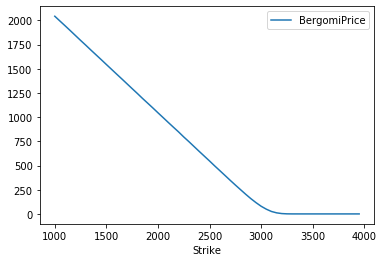

In [8]:
Bergomi_PlotPrice = BergomiCallData.set_index('Strike')
Bergomi_PlotPrice.plot()

Par conséquent, il est possible de tracer la volatilité implicite du modèle de Bergomi à deux facteurs.

Cette volatilité implicite est la volatilité $\sigma_{imp}$ tel que le prix actuel des options sur S&P500 calculé par la formule de Black Scholes, est égal à celui calculé par le modèle de Bergomi à deux facteurs. Plus particulièrement, $\sigma_{imp}$ est défini tel que :

$$
C_{BS}(\sigma_{imp}^2,T,K) = C_{Bergomi}(T,K)
$$

Ce qui équivaut à établir que $\sigma_{imp}$ est racine de la fonction $C_{BS}(\sigma^2,T,K) - C_{Heston}(T,K)$:

$$
\sigma_{imp} = root_{\sigma} (C_{BS}(\sigma^2,T,K) - C_{Heston}(T,K))
$$

Ici, la volatilité implicite sera calculée pour l'ensemble des Calls de ténor un an pour tous les Strikes.

Sachant que le prix de Bergomi à deux facteur a déjà été calculé pour l'ensemble des Calls, la formule de Black Scholes est aussi implémentée :

In [9]:
def CallFormulaBS(S0,r,K,T,sigma):
    d1 = (math.log(S0/K)+(r+(sigma**2/2))*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    C = S0*sps.norm.cdf(d1) - K*math.exp(-r*T)*sps.norm.cdf(d2)
    return C

De ce fait, le calcul de la volatilité implicite pour l'ensemble des Calls s'effectue grâce à la fonction fsolve de scipy.optimize pour trouver la racine de la fonction de variable $\sigma$ mesurant la différence entre le prix Black Scholes de l'option et celui du modèle de Bergomi :

In [77]:
def ImpliedVolCall(S0,r,K,T,Call):
    _S0, _r, _K, _T, _Call = S0,r,K,T,Call
    m = _S0/_K
    difference_call = lambda sigma : _Call - CallFormulaBS(_S0, _r, _K, _T,sigma)
    iv = spop.brentq(difference_call, -2,2)
    
    # On rend manquant les volatilités implicite de trop faible valeurs
    return np.nan if iv <= 1.0e-6 else iv

Le calcul de la volatilité implicite peut donc être effectué sur l'ensemble des prix Mid des options exprimés en fonction du strike $K$, sachant que tous les paramètres requis en entrée sont à notre disposition :

In [78]:
def all_implied_Vol_Call(data):
    S0 = 3041.31
    r = 0.17/100
    K = data["Strike"]
    T = 1
    BergomiPrice = data["BergomiPrice"]
    return float(ImpliedVolCall(S0,r,K,T,BergomiPrice))

In [79]:
BergomiCallData["Bergomi_IV"] = BergomiCallData.apply(all_implied_Vol_Call, axis = 1)

De ce fait, la volatilité implicite de Bergomi peut être tracée en fonction du Strike des Calls pour le ténor d'un an :

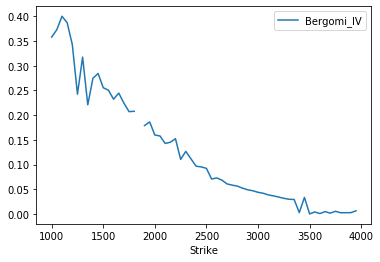

In [80]:
Bergomi_PlotPrice = BergomiCallData[["Strike","Bergomi_IV"]].set_index('Strike')
Bergomi_PlotPrice.plot()

Il est possible de constater que la volatilité implicite sous le modèle de Bergomi semble graphiquement correct, malgré une apparence légèrement en dent de scie qui est probablement causé par le bruit issue de l'estimation Monte Carlo. En effet, la forme de cette volatilité implcite est typique de ce qui peut être observé sur le marché, comme cela pourrait être constaté ultérieurement dans le projet.

Par la suite, il convient d'effectuer une calibration du modèle de Bergomi à deux facteurs pour les options sur S&P500.

## Calibration du modèle de Bergomi à deux facteurs pour les options sur S&P500

La démarche concernant la calibration du modèle de Bergomi à deux facteurs a largement été inspirée des travaux de Wei Fang, étudiant du MSc in Mathematics and Finance de l'Imperial College London, ainsi que de la littérature même de M. Lorenzo Bergomi et M. Guyon, sur ce modèle et ses applications pour le pricing des options cliquets.

L'approche naturelle pour calibrer les paramètres d'un modèle de Pricing est de chercher ceux pouvant minimiser directement l'erreur quadratique des prix des options sur VIX. Cependant, le pricing se faisant par Monte Carlo, le temps de calcul ainsi que le bruit résultant des simulations rendent la calibration impossible à effectuer via ce biais. Ainsi, une autre approche a été proposée par Bergomi et Guyon. Il s'agissait de calibrer non pas le modèle en lui même, mais selon la dynamique des volatilités de divers produits, c'est à dire dans ce cas de figure celle des Variance Swap, puis des options sur S&P500. Cette approche a la forte avantage d'être indépendante de tout spécification de modèle.

Le Swap de Variance du S&P500 est un instrument clé dans la calibration du modèle. Il convient donc de le définir soigneusement. Par ailleurs, faute de données disponibles sur le site CBOE concernant ce produit, il n'y eu d'autres possibilités que de valoriser manuellement le prix des Variance Swap pour toutes les maturités, exprimé en point de volatilités, à partir du prix des options sur S&P500 :

### Définition et pricing des Variance Swap sur S&P500

Le swap de variance est un produit contingent permettant d'échanger au moment de la maturité $T$ la volatilité réalisée du sous-jacent, qui est ici l'indice du S&P500, contre un montant fixe valant $N\sigma_K^2$, $N$ étant le nominal du contrat et $\sigma_K^2$ la volatilité 'Strike'.

De ce fait, en considérant des prix du marché et $n$ le nombre de jours ouvrés jusqu'à la maturité $T$, le pay-off de l'actif à maturité est empiriquement égal à :

$$
H_T = \frac{250N}{n}\sum_{i=1}^{n}(log(\frac{S_i}{S_{i-1}}))^2 - N\sigma_K^2
$$

A temps continu, en posant $\sigma_s$ la volatilité stochastique du sous-jacent $S$, la dynamique du prix de ce dernier est donnée par :

$$
\frac{dS_t}{S_t} = \mu_t dt + \sigma_t dW_t
$$

Et le pay-off devient :

$$
H_T = N(\frac{1}{T}\int_{0}^{T}\sigma_s^2ds - \sigma_K^2)
$$

On suppose le notionel $N$ égal à un. La valeur d'un tel contrat est égale à l'espérance sous la probabilité risque neutre des flux futurs actualisés par le taux sans risque $r$, en accord avec le théorème fondamental de la valorisation des actifs. De ce fait, en nommant $F_0^T$ cette valeur actuelle pour un Variance Swap de maturité $T$ et en considérant $\mathbb{Q}$ la probabilité risque neutre, celle ci est égale à :

$$
F_0^T = e^{-rT}\mathbb{E}^{Q}[H_T] = e^{-rT}\mathbb{E}^{Q}[N(\frac{1}{T}\int_{0}^{T}\sigma_s^2ds - \sigma_K^2)] 
$$

Par absence d'opportunité d'arbitrage, la valeur actuelle du contrat doit être nulle. Plus précisément, la variance 'Strike' est valorisée de sorte que cela se produise. Une telle variance est appelée 'fair variance', et est définie en fonction de la maturité $T$ du contrat telle que :

$$
F_0^T = e^{-rT}\mathbb{E}^{Q}[H_T] = e^{-rT}\mathbb{E}^{Q}[N(\frac{1}{T}\int_{0}^{T}\sigma_s^2ds - \sigma_K^2)] = 0
$$

C'est à dire :

$$
(\sigma_0^T)^2 = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}\sigma_s^2ds]
$$


Par ailleurs, en appliquant la formule d'Itô à $(ln(S_t))_t$, sa dynamique est égale à :

$$
dln(S_t) = (\mu_t - \frac{\sigma_t}{2})dt + \sigma_t dW_t = (\mu_t dt + \sigma_t dW_t) - \frac{\sigma_t}{2}dt = \frac{dS_t}{S_t} - \frac{\sigma_t}{2}dt
$$

Ainsi par intégration entre 0 et $T$ :

$$
\frac{1}{2}\int_0^T \sigma_s ds = \int_0^T \frac{dS_s}{S_s} - ln(\frac{S_T}{S_0})
$$

Et donc la variance totale du processus $S$ est égale à :

$$
\frac{1}{T}\int_0^T \sigma_s ds = \frac{2}{T}(\int_0^T \frac{dS_s}{S_s} - ln(\frac{S_T}{S_0}))
$$

De ce fait, la 'fair variance' du variance Swap sur $S$ de maturité $T$ est donnée par :

$$
(\sigma_0^T)^2  = \mathbb{E}^{Q}[\frac{2}{T}(\int_0^T \frac{dS_s}{S_s} - ln(\frac{S_T}{S_0}))]
$$

C'est à dire :

$$
(\sigma_0^T)^2 = \frac{2}{T}\mathbb{E}^{Q}[\int_0^T \frac{dS_s}{S_s}] - \frac{2}{T}\mathbb{E}^{Q}[ln(\frac{S_T}{S_0}))]
$$

Or sous la probabilité risque neutre $\mathbb{Q}$, en posant $B_T$ le $\mathbb{Q}$ mouvement brownien pouvant être construit via le théorème de Girsanov,

$$
\frac{dS_t}{S_t} = r dt + \sigma_t dW_t
$$

D'où : $\mathbb{E}^{Q}[\int_0^T \frac{dS_s}{S_s}] = rT$ et ainsi

$$
(\sigma_0^T)^2 = \frac{2}{T}(rT - \mathbb{E}^{Q}[ln(\frac{S_T}{S_0})])
$$

De ce fait, il convient de trouver l'expression de $\mathbb{E}^{Q}[ln(\frac{S_T}{S_0})]$.

Pour cela, considérons le log-contrat de sous jacent $S$, qui est un contrat délivrant un pay-off égal à :

$$
f(S_T) = \frac{2}{T}(ln(\frac{S_0}{S_T}) + \frac{S_T}{S_0}-1)
$$

Considérons $F$ un seuil, qui est ici la valeur du strike $K$ selon laquelle les prix actuels des Calls et des Puts de maturité $T$ sont égaux, c'est à dire $F = S_0 e^{rT}$ donc le prix forward à maturité $T$ de l'actif $S$, d'après la formule de Parité Call Put à l'instant 0. En effet :

$$
C_0 - P_0 = S_0 - Ke^{-rT} = S_0 - S_0*e^{-rT}*e^{rT} = S_0 -S_0  = 0
$$

De ce fait, il est possible de décomposer le pay_off $f(S_T)$ de la manière suivante :

$$
f(S_T) = f(F) + f'(F)(S_T - F) + \int_0^F f''(K)(K-S_T)_{+}dK + \int_F^{+\infty} f''(K)(S_T-K)_{+}dK
$$

Or : 

- $f'(S_T)= \frac{2}{T}(\frac{1}{S_0} - \frac{1}{S_T})$
- $f''(S_T) = \frac{2}{T}*\frac{1}{S_T^2}$

De ce fait :

$$
\frac{2}{T}(ln(\frac{S_0}{S_T}) + \frac{S_T}{S_0}-1) = \frac{2}{T}(ln(\frac{S_0}{F}) + \frac{F}{S_0}-1) + \frac{2}{T}(\frac{1}{S_0} - \frac{1}{F})(S_T - F) + \frac{2}{T}\int_0^F \frac{1}{K^2}(K-S_T)_{+}dK + \frac{2}{T}\int_F^{\infty} \frac{1}{K^2}(S_T-K)_{+}dK 
$$

D'où :

$$
- ln(\frac{S_0}{F}) = - \frac{S_T - F}{F} + \int_0^F \frac{1}{K^2}(K - S_T)_{+}dK + \int_F^{\infty} \frac{1}{K^2}(S_T - K)_{+}dK
$$

Ainsi, l'espérance de cette quantité est égale à :

$$
- \mathbb{E}^{Q}[ln(\frac{S_T}{F})] = - \frac{\mathbb{E}^{Q}[S_T] - F}{F} + \int_0^F \frac{1}{K^2}\mathbb{E}^{Q}[(K - S_T)_{+}]dK + \int_F^{\infty} \frac{1}{K^2}\mathbb{E}^{Q}[(S_T - K)_{+}]dK \\
$$

Sachant que les prix actuels des Calls et Puts en fonction du strike $K$ et de la maturité $T$ sont respectivement égaux à : $P(K,T) = e^{-rT} \mathbb{E}^{Q}[(S_T - K)_{+}]$, $C(K,T) = e^{-rT} \mathbb{E}^{Q}[(K - S_T)_{+}]$, et que $\mathbb{E}^{Q}[S_T] = S_0e^{rT}$ :

$$
- \mathbb{E}^{Q}[ln(\frac{S_T}{F})] = - [\frac{S_0}{F}e^{rT} - 1] + e^{rT}\int_0^F \frac{P(K,T)}{K^2}dK + e^{rT}\int_F^{\infty} \frac{C(K,T)}{K^2}dK
$$

Par ailleurs, sachant que $ln(\frac{S_T}{S_0}) = ln(\frac{S_T}{F}) + ln(\frac{F}{S_0})$, alors nous obtenons :

$$
- \mathbb{E}^{Q}[ln(\frac{S_T}{S_0})] = - ln(\frac{F}{S_0}) - \mathbb{E}^{Q}[ln(\frac{S_T}{F})]
$$

Ainsi :

$$
- \mathbb{E}^{Q}[ln(\frac{S_T}{S_0})] = - ln(\frac{F}{S_0}) - [\frac{S_0}{F}e^{rT} - 1] + e^{rT}\int_0^F \frac{P(K,T)}{K^2}dK + e^{rT}\int_F^{\infty} \frac{C(K,T)}{K^2}dK
$$

Finalement, la 'fair variance' annulant la valeur à l'instant $0$ du Variance Swap sur l'actif $S$ et de maturité $T$ est donnée par :

$$
(\sigma_0^T)^2 = \frac{2}{T}(rT - ln(\frac{F}{S_0}) - [\frac{S_0}{F}e^{rT} - 1] + e^{rT}\int_0^F \frac{P(K,T)}{K^2}dK + e^{rT}\int_F^{\infty} \frac{C(K,T)}{K^2}dK)
$$

Or, sachant que $F = S_0e^{rT}$, le prix forward de $S$ à maturité $T$, l'expression de la 'fair variance' se simplifie comme suit :

$$
(\sigma_0^T)^2 = \frac{2}{T}(rT - ln(\frac{S_0e^{rT}}{S_0}) - [\frac{S_0}{S_0e^{rT}}e^{rT} - 1] + e^{rT}\int_0^F \frac{P(K,T)}{K^2}dK + e^{rT}\int_F^{\infty} \frac{C(K,T)}{K^2}dK)
$$

d'où :

$$
(\sigma_0^T)^2 = \frac{2}{T}e^{rT}(\int_0^F \frac{P(K,T)}{K^2}dK + \int_F^{\infty} \frac{C(K,T)}{K^2}dK)
$$

Pour autant, sachant que la cotation des options s'effectue pour des Strikes exprimés en nombre entier, il n'est pas possible d'avoir un prix d'option dont le strike est exactement égal au prix forward $F$ du sous-jacent $S$ au moment de la cotation. C'est pourquoi il convient de considérer $K_0$, le plus grand strike qui est plus petit que le prix forward $F$. De ce fait, le prix du Variance Swap est donné par :

$$
(\sigma_0^T)^2 = \frac{2}{T}e^{rT}(\int_0^{K_0} \frac{P(K,T)}{K^2}dK + \int_{K_0}^{\infty} \frac{C(K,T)}{K^2}dK)+\frac{2}{T}e^{rT}\int_{K_0}^{F} \frac{P(K,T) - C(K,T)}{K^2}dK
$$

Qui peut être approximé par : 

$$
(\sigma_0^T)^2 \approx \frac{2}{T}e^{rT}(\int_0^{K_0} \frac{P(K,T)}{K^2}dK + \int_{K_0}^{\infty} \frac{C(K,T)}{K^2}dK)-\frac{1}{T} \frac{(F - K_0)^2}{K_0^2}
$$

Ainsi, il est possible à partir du prix des Options sur S&P500 de valoriser la 'fair variance' annulant la valeur à l'instant $0$ des variance swaps sur le même sous jacent pour chaque maturité $T$. Il s'agit de cette quantité qui est côté sur le marché Over The Counter en tant que prix des variances swaps.

Sachant qu'il s'agira des prix du marché des options sur S&P500 qui seront exploités pour la valorisation des variance swaps, il convient d'établir une expression en temps discret de $(\sigma_0^T)^2$. Celle ci est égale à :

$$
(\hat{\sigma}_0^T)^2 = \frac{2}{T}e^{rT}(\sum_{i=1}^{N_{Puts}} \frac{Put(K_i,T)}{{K_i}^2}(K_i - K_{i-1}) + \sum_{j=1}^{N_{Calls}} \frac{Call(K_j,T)}{{K_j}^2}(K_j - K_{j-1}))-\frac{1}{T} [\frac{F}{K_0}-1]^2
$$

$Put(K_i,T)$ et $Call(K_j,T)$ étant les prix actuels des puts et calls de maturité $T$ sur S&P500 pour les différents strikes $K_i$ et $K_j$. La quantité $-\frac{1}{T} \frac{(F - K_0)^2}{K_0^2}$ est un facteur d'ajustement issu de la considération de $K_0$ dans le calcul.

Sont exclus du calcul les options Out of Money par rapport au prix forward $F$ du sous-jacent $S$.

Cela fait sens par rapport à la formule de la variance swap dans le cas continu étant donné que :

- Dans le cas d'un Put, celui ci est Out of Money lorsque son strike $K_{Put}$ est telle que : $K_{Put} \geq F$
- Dans le cas d'un Call, celui ci est Out of Money lorsque son strike $K_{Call}$ est telle que : $K_{Call} \leq F$

Il convient donc dans un premier temps de charger les données contenant le prix des options sur SPX.

#### Chargement des données contenant le prix des options sur SPX

Les données des options sur l'indice S&P500 ont été une fois de plus téléchargés depuis la plateforme Cboe delayed quotes, et proviennent cette fois ci d'une cotation effectuée le 12 Juin 2020. La date d'expiration pour chaque option est renseignée, ce qui permet d'en déduire chaque maturité.

In [15]:
CallPriceSPX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/SPXCallData.xlsx")
PutPriceSPX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/SPXPutData.xlsx")

Dans un premier temps, il convient d'harmoniser le format de la date d'expiration, et ainsi de construire la variable de maturité pour chaque option sachant que la cotation a eu lieu le 12 Juin 2020.

In [16]:
CallPriceSPX.head()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike
0,2020-06-12,SPXW200612C00500000,2519.3,0.0,2519.6,2567.6,0,0.02,0.9999,0.0,1,500
1,2020-06-12,SPXW200612C00600000,0.0,0.0,2419.6,2467.6,0,0.02,0.9999,0.0,0,600
2,2020-06-12,SPXW200612C00700000,0.0,0.0,2319.6,2367.6,0,0.02,0.9999,0.0,1,700
3,2020-06-12,SPXW200612C00800000,2187.9,0.0,2219.6,2267.6,0,0.02,0.9998,0.0,1,800
4,2020-06-12,SPXW200612C00900000,0.0,0.0,2119.6,2167.6,0,0.02,0.9998,0.0,0,900


In [17]:
from datetime import timedelta
from datetime import date

n = len(CallPriceSPX['Expiration_Date'])
Expiration_Date = CallPriceSPX['Expiration_Date']

# Déclaration du vecteur Date de composantes égales au 12 Juin 2020
Today=[0 for i in range(n)]
for i in range(n):
    Today[i] = str('2020-06-12')
Today = pd.to_datetime(Today)

# Expression de la différence entre l'expiration et la date du 12 Juin 2020
time_difference = Expiration_Date - Today

# Conversion de la différence en nombre entier de jours, sachant que le type du vecteur est timedelta
m = len(time_difference)
Time_difference = [int(time_difference[i]/np.timedelta64(1, 'D')) for i in range(m)]

# Calcul de la maturité des Options et ajout dans le jeu de données
CallPriceSPX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]
PutPriceSPX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]

Il est par ailleurs coutume d'utiliser comme valeur de référence le prix Mid, qui est la moyenne entre les prix Bid et Ask. qui est considéré comme le prix représentant au mieux celui de l'option observé sur le marché. De ce fait, nous implémentons la fonction calculant cette quantité. Si tous les deux prix sont manquantes, on utilise le prix Last qui est le prix fixé lors de la dernière transaction.

In [18]:
def get_fair_price(data):
    Bid = data["Bid"]
    Ask = data["Ask"]
    Last = data["Last_Sale"]
    # On retourne 0 si le bid ou le ask est manquante
    if np.isnan(Bid) or np.isnan(Ask):
        return 0.0
    # On retourne le dernier prix de trade si le bid ou le ask est nul
    elif Bid == 0.0 or Ask == 0.0:
        return Last
    else:
        return (Bid+Ask)/2.0

In [19]:
# Rajout du prix Mid au jeu de données
CallPriceSPX['Mid'] = CallPriceSPX.apply(get_fair_price, axis=1)
PutPriceSPX['Mid'] = PutPriceSPX.apply(get_fair_price, axis=1)

In [20]:
CallPriceSPX.tail()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid
8746,2022-12-16,SPX221216C04500000,25.00,-0.75,15.0,28.9,1,0.1682,0.0720,0.0002,573,4500,2.515068,21.95
8747,2022-12-16,SPX221216C04600000,19.56,0.06,9.4,29.4,5,0.1685,0.0618,0.0002,398,4600,2.515068,19.40
8748,2022-12-16,SPX221216C04700000,17.06,0.66,6.2,26.2,5,0.1690,0.0531,0.0001,1326,4700,2.515068,16.20
8749,2022-12-16,SPX221216C04800000,20.40,0.00,3.7,23.7,0,0.1699,0.0462,0.0001,602,4800,2.515068,13.70
8750,2022-12-16,SPX221216C04900000,13.00,-0.25,10.0,14.6,1,0.1719,0.0412,0.0001,571,4900,2.515068,12.30


In [21]:
PutPriceSPX.head()

,Expiration_Date,Puts,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid
0,2020-06-12,SPXW200612P00500000,0.00,0.0,0.0,20.00,0,0.020,-0.0001,0.0,0,500,0.00274,0.00
1,2020-06-12,SPXW200612P00600000,0.00,0.0,0.0,20.00,0,0.020,-0.0001,0.0,0,600,0.00274,0.00
2,2020-06-12,SPXW200612P00700000,0.00,0.0,0.0,20.00,0,0.020,-0.0001,0.0,0,700,0.00274,0.00
3,2020-06-12,SPXW200612P00800000,0.05,0.0,0.0,0.05,0,0.020,-0.0001,0.0,50,800,0.00274,0.05
4,2020-06-12,SPXW200612P00900000,0.00,0.0,0.0,20.00,0,36.733,-0.0001,0.0,0,900,0.00274,0.00


#### Valorisation des swaps de variance sur S&P500 à partir des données

Rappelons qu'à partir du prix des options sur S&P500, il est possible de valoriser les swaps de variance sur le même sous-jacent grâce à la formule suivante :

$$
(\hat{\sigma}_0^T)^2 = \frac{2}{T}e^{rT}(\sum_{i=0}^{N_{Puts}} \frac{Put(K_i,T)}{{K_i}^2}(K_i - K_{i-1}) + \sum_{j=0}^{N_{Calls}} \frac{Call(K_j,T)}{{K_j}^2}(K_j - K_{j-1}))-\frac{1}{T} [\frac{F}{K_0}-1]^2
$$

$Put(K_i,T)$ et $Call(K_j,T)$ étant les prix actuels des puts et calls de maturité $T$ sur S&P500 pour les différents strikes $K_i$ et $K_j$.

Il a été dit précédemment que les options hors de la monnaie au regard du prix forward actuel du S&P500 doivent être exclus, puisque leur prix actuel est nulle. Ainsi, on ne retient que les options concernés. Par ailleurs, ce prix forward est une composante principale pour le calcul du prix des swaps de variance.

Pour autant, le calcul du prix forward du sous-jacent est un exercice délicat, qui doit être établit à partir d'une calibration aux moindres carrés du fait de la variété des prix du marché des options selon chaque Strike et Maturité :

##### Calcul du prix forward $F$ de l'indice du S&P500 pour chaque maturité

Le calcul du prix forward $F$ repose sur la formule de parité Call Put, pouvant être exprimée à l'instant 0 comme suit, sachant que le prix actuel d'une option dépend du Strike et de la maturité :

$$
Call(K,T) - Put(K,T) = S_0 - K.B(0,T)
$$

De ce fait, cela est équivalent à :

$$
Call(K,T) - Put(K,T) = B(0,T)(F(T) - K)
$$

$F(T)$ est le prix forward de l'indice S&P500 évalué à l'instant 0, égal à $\frac{S_0}{B(0,T)}$, qui dépend par conséquent uniquement de la maturité $T$ des options. Cependant, il convient d'utiliser directement les données des options pour calculer le prix forward, au lieu de la valeur actuel de l'indice du S&P500, égale par ailleurs à 3041.31 en ce 13 Juin 2020.

Ainsi, en disposant des données du marché des options, le calcul du prix forward $F$ s'effectue par calibration, en supposant qu'il est solution du problème de minimisation des moindres carrés suivant, pour chaque maturité $T$ :

$$
F(T) = argmin_{F} \sum_{i=0}^{N_{Puts} + N_{Calls}} (Call(K_i,T) - Put(K_i,T) - B(0,T)(F-K_i))^2 
$$

Le prix actuel d'une obligation zéro coupon de taux sans risque $r$, utilisé comme facteur d'actualisation (Discount Factor $DF$), est donné par $B(0,T) = e^{-rT}$. $r$ peut être extrait à partir du taux des Bons du Trésors Américains pour les prêts des différentes maturités $T$. Cependant, cela requiert de reconstruire la courbe de taux sans risque, qui peut prendre du temps. Ainsi, il convient de les considérer eux aussi dans le problème de minimisation pour chaque maturité $T$, ce qui permet ainsi d'en établir une expression plus précise (le taux sans risque étant en réalité non constant et donc stochastique), ainsi que davantage de degrés de liberté. Ainsi, en posant $\theta = \{DF,F\}$ les paramètres à optimiser, le problème de minimisation devient :

$$
\hat{\theta} = (B(0,T), F(T)) = argmin_{\theta} \sum_{i=0}^{N_{Puts} + N_{Calls}} (Call(K_i,T) - Put(K_i,T) - DF(F-K_i))^2 
$$

De ce fait, l'implémentation débute par celle de la fonction de minimisation, liée à la formule de parité Call Put :

In [22]:
def CallPutParity(expiration,*params):
    DF, F = params
    
    # On filtre les données des options selon leur date d'expiration
    PutPriceSPX_by_matur = PutPriceSPX[PutPriceSPX['Expiration_Date'] == expiration][['Strike','Maturity', 'Mid']]
    CallPriceSPX_by_matur = CallPriceSPX[CallPriceSPX['Expiration_Date'] == expiration][['Strike','Maturity', 'Mid']]
    
    # On réindexe correctement les nouveaux jeux de données
    n = len(CallPriceSPX_by_matur)
    m = len(PutPriceSPX_by_matur)
    CallPriceSPX_by_matur['Index'] =[i for i in range (n)]
    PutPriceSPX_by_matur['Index'] =[i for i in range (m)]
    CallPriceSPX_by_matur = CallPriceSPX_by_matur.set_index('Index')
    PutPriceSPX_by_matur = PutPriceSPX_by_matur.set_index('Index')
    
    # On considère le Strike et le prix Mid des options et les résidus moindres carrés sont calculés
    K = CallPriceSPX_by_matur["Strike"]
    MidCall = CallPriceSPX_by_matur["Mid"]
    MidPut = PutPriceSPX_by_matur["Mid"]
    
    residuals = [(MidCall[i] - MidPut[i] - DF*(F-K[i]))**2 for i in range(n)]
    MSE = np.sum(residuals)
    return MSE

Par la suite, l'optimisation est effectuée à chaque maturité $T$ existante afin de déterminer le facteur d'actualisation $B(0,T)$ ainsi que le prix forward du S&P500 $F$ :

In [23]:
# extraction de chaque date d'expiration
Expiration = CallPriceSPX["Expiration_Date"].unique()

# Création du vecteur comprenant le discount factor et le prix forward à chaque maturité
Forward_SPX = []
for exp in Expiration :
    optimize_function = lambda params : CallPutParity(exp,*params)
    
    # On initie les paramètres initiaux. Intuitivement, le zéro coupon sera initialisé à 1, tandis que le prix forward à 2956
    param_initiaux = [1,3045]
    ThetaOpti = spop.fmin(optimize_function, param_initiaux, maxiter = 300, maxfun = 300, disp = False)
    Forward_SPX.append(ThetaOpti)

De ce fait, il convient de créer un jeu de données comprenant l'ensemble des résultats ci dessus, c'est à dire le prix de l'obligation zéro-coupon sans risque servant de facteur d'actualisation, ainsi que du prix forward de l'indice du S&P500, et cela en fonction de toutes les maturités existantes pour les options sur l'indice.

In [24]:
n = len(Forward_SPX)

# Déclaration des valeurs du discount factor et du prix forward calculés selon deux vecteurs distingts
ZC_Bond = [Forward_SPX[i][0] for i in range(n)]
Forward_Price = [Forward_SPX[i][1] for i in range(n)]

# Maturité unique de chaque option
Maturity = CallPriceSPX['Maturity'].unique()

# Création du jeu de données
Index = [i for i in range(n)]
Forward_Data = pd.DataFrame(index = Index)
Forward_Data['Expiration_Date'] = Expiration
Forward_Data['ZC_Bond'] = ZC_Bond
Forward_Data['Forward_SPX'] = Forward_Price

In [25]:
print(Forward_Data)

   Expiration_Date   ZC_Bond  Forward_SPX
0       2020-06-12  1.000174  3043.142613
1       2020-06-15  0.999933  3036.289019
2       2020-06-17  0.999969  3036.193209
3       2020-06-19  0.999784  3034.353592
4       2020-06-22  0.999924  3035.442695
5       2020-06-24  0.999928  3035.452050
6       2020-06-26  0.999860  3035.412727
7       2020-06-29  0.999763  3034.383742
8       2020-06-30  0.999814  3034.641996
9       2020-07-01  0.999623  3034.236051
10      2020-07-02  0.999770  3034.204769
11      2020-07-06  0.999919  3033.634475
12      2020-07-08  1.000109  3033.600486
13      2020-07-10  0.999768  3032.639948
14      2020-07-13  0.999952  3033.032563
15      2020-07-17  0.999376  3032.276531
16      2020-07-24  0.999239  3032.304679
17      2020-07-31  0.999694  3031.995908
18      2020-08-07  0.999557  3030.518257
19      2020-08-21  0.999126  3027.942072
20      2020-08-31  0.999202  3026.898085
21      2020-09-18  0.998835  3024.285207
22      2020-09-30  0.999168  3023

##### Jointure des données et calcul du prix des Variance Swaps

Il convient maintenant de faire la jointure entre le nouveau jeux de données contenant les prix forward ainsi que celui du prix des options, en fonction de la date d'expiration, qui est considérée comme index pour chacune des jeux de données. Pour cela, on définit le nouvel index pour les deux jeux de données.

In [26]:
PutPriceSPX = PutPriceSPX.set_index("Expiration_Date")
CallPriceSPX = CallPriceSPX.set_index("Expiration_Date")
Forward_Data = Forward_Data.set_index("Expiration_Date")

Ainsi, la jointure (selon une procédure Left Join) se fait selon l'index qui est la date d'expiration des options.

In [27]:
# On joint selon une procédure Left Join la table des Calls avec celle du prix du sous-jacent, selon l'index
CallPriceSPX = CallPriceSPX.join(Forward_Data)
PutPriceSPX = PutPriceSPX.join(Forward_Data)

# On réinitialise l'index :
CallPriceSPX = CallPriceSPX.reset_index()
PutPriceSPX = PutPriceSPX.reset_index()

In [28]:
CallPriceSPX.head()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid,ZC_Bond,Forward_SPX
0,2020-06-12,SPXW200612C00500000,2519.3,0.0,2519.6,2567.6,0,0.02,0.9999,0.0,1,500,0.00274,2543.6,1.000174,3043.142613
1,2020-06-12,SPXW200612C00600000,0.0,0.0,2419.6,2467.6,0,0.02,0.9999,0.0,0,600,0.00274,2443.6,1.000174,3043.142613
2,2020-06-12,SPXW200612C00700000,0.0,0.0,2319.6,2367.6,0,0.02,0.9999,0.0,1,700,0.00274,2343.6,1.000174,3043.142613
3,2020-06-12,SPXW200612C00800000,2187.9,0.0,2219.6,2267.6,0,0.02,0.9998,0.0,1,800,0.00274,2243.6,1.000174,3043.142613
4,2020-06-12,SPXW200612C00900000,0.0,0.0,2119.6,2167.6,0,0.02,0.9998,0.0,0,900,0.00274,2143.6,1.000174,3043.142613


In [29]:
PutPriceSPX.tail()

,Expiration_Date,Puts,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid,ZC_Bond,Forward_SPX
8746,2022-12-16,SPX221216P04500000,1385.00,0.0,1538.7,1586.7,0,0.1665,-0.9251,0.0002,19,4500,2.515068,1562.7,0.989136,2944.171664
8747,2022-12-16,SPX221216P04600000,1609.60,0.0,1633.6,1681.6,0,0.1655,-0.9369,0.0001,4,4600,2.515068,1657.6,0.989136,2944.171664
8748,2022-12-16,SPX221216P04700000,1783.38,0.0,1729.4,1777.4,0,0.1646,-0.9469,0.0001,29,4700,2.515068,1753.4,0.989136,2944.171664
8749,2022-12-16,SPX221216P04800000,1881.55,0.0,1825.8,1873.8,0,0.1635,-0.9555,0.0001,48,4800,2.515068,1849.8,0.989136,2944.171664
8750,2022-12-16,SPX221216P04900000,1979.26,0.0,1922.7,1970.7,0,0.1623,-0.9629,0.0001,64,4900,2.515068,1946.7,0.989136,2944.171664


De ce fait, il est possible de calculer le prix des swaps de variance du S&P500, en se rappelant qu'à partir du prix des options sur S&P500, le prix des swaps de variance pour ce même sous jacent est donné par la formule suivante :

$$
(\hat{\sigma}_0^T)^2 = \frac{2}{T}e^{rT}(\sum_{i=1}^{N_{Puts}} \frac{Put(K_i,T)}{{K_i}^2}(K_i - K_{i-1}) + \sum_{j=1}^{N_{Calls}} \frac{Call(K_j,T)}{{K_j}^2}(K_j - K_{j-1}))-\frac{1}{T} [\frac{F}{K_0}-1]^2
$$

$Put(K_i,T)$ et $Call(K_j,T)$ étant les prix actuels des puts et calls de maturité $T$ sur S&P500 pour les différents strikes $K_i$ et $K_j$.

Par ailleurs, sachant que le prix actuel d'une obligation zéro-coupon de taux sans risque, servant de facteur d'actualisation, peut être donné par $B(0,T) = e^{-rT}$ dans le cas de taux constant, il convient de généraliser la formule ci dessus avec la formule générale de l'obligation, sachant que celle ci a été calculée pour toute maturité en même temps que le prix forward du S&P500 : 

$$
(\hat{\sigma}_0^T)^2 = \frac{2}{T*B(0,T)}(\sum_{i=1}^{N_{Puts}} \frac{Put(K_i,T)}{{K_i}^2}(K_i - K_{i-1}) + \sum_{j=1}^{N_{Calls}} \frac{Call(K_j,T)}{{K_j}^2}(K_j - K_{j-1}))-\frac{1}{T} [\frac{F}{K_0}-1]^2
$$

L'implémentation donne donc :

In [30]:
# Exclusion des Puts et Calls Hors de la monnaie
ATMCallPriceSPX = CallPriceSPX[CallPriceSPX['Strike'] <= CallPriceSPX["Forward_SPX"]]
ATMPutPriceSPX = PutPriceSPX[PutPriceSPX['Strike'] >= PutPriceSPX["Forward_SPX"]]

In [31]:
Maturity = CallPriceSPX["Maturity"].unique()
Expiration = CallPriceSPX["Expiration_Date"].unique()
n = len(Expiration)

Index = [i for i in range(n)]
VSPrice = pd.DataFrame(index = Index)

VSPrice['Expiration_Date'] = Expiration
VSPrice['Maturity'] = Maturity

Price_VS = []
for exp in Expiration :
    
    # On filtre le prix des options par date d'expiration
    ATMPutPriceSPX_by_matur = ATMPutPriceSPX[ATMPutPriceSPX['Expiration_Date'] == exp][['Maturity','Strike', 'Mid','ZC_Bond', "Forward_SPX"]]
    ATMCallPriceSPX_by_matur = ATMCallPriceSPX[ATMCallPriceSPX['Expiration_Date'] == exp][['Maturity','Strike', 'Mid','ZC_Bond',"Forward_SPX"]]

    # Déclaration du prix forward, du Bond Zéro Coupon, et de K0, plus grand strike en dessous du prix forward pour chaque maturité
    F = ATMCallPriceSPX_by_matur['Forward_SPX'].iloc[1]
    ZC_Bond = ATMCallPriceSPX_by_matur['ZC_Bond'].iloc[1]
    K0 = ATMCallPriceSPX_by_matur['Strike'].iloc[-1]
    
    # Déclaration de la maturité, qui est la même en fonction des dates d'expiration
    T = ATMCallPriceSPX_by_matur['Maturity'].iloc[1]
    
    # Calcul du prix du variance swap pour la maturité en question selon la formule établie
    Nput = len(ATMPutPriceSPX_by_matur)
    Ncall = len(ATMCallPriceSPX_by_matur)
    
    SumPut = 0
    SumCall = 0
    for i in range (1,Nput) :
        SumPut += (ATMPutPriceSPX_by_matur['Mid'].iloc[i]/(ATMPutPriceSPX_by_matur['Strike'].iloc[i])**2)*(ATMPutPriceSPX_by_matur['Strike'].iloc[i] - ATMPutPriceSPX_by_matur['Strike'].iloc[i-1])
    for i in range (1,Ncall) :
        SumCall += (ATMCallPriceSPX_by_matur['Mid'].iloc[i]/(ATMCallPriceSPX_by_matur['Strike'].iloc[i])**2)*(ATMCallPriceSPX_by_matur['Strike'].iloc[i] - ATMCallPriceSPX_by_matur['Strike'].iloc[i-1])
    Price_VS.append(math.sqrt((2/(T*ZC_Bond))*(SumPut + SumCall) - (1/T)*(((F/K0)-1)**2)))
                    
VSPrice['Fair_Variance'] = Price_VS

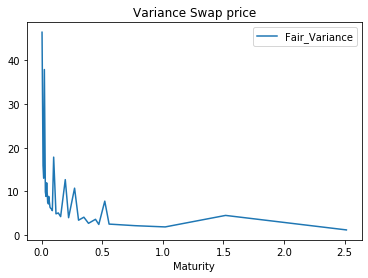

In [32]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
VS_Price = VSPrice[['Maturity', 'Fair_Variance']].set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
VS_Price.plot(title = 'Variance Swap price')

Malheureusement, les résultats obtenus ne sont guères satisfaisants, faisant donc craindre soit des erreurs de calculs, soit du bruit dans les données, soit des limites dans cette approche. N'ayant aucun moyen d'obtenir le prix des swaps de variances à partir des données d'options, il a été décidé de valoriser les variances swaps à partir du modèle d'Heston pour chaque maturité, avec des paramètres calibrés sur un autre projet sur les mêmes données des options sur S&P500 que celles téléchargées dans ce projet. Malgré les limites de ce modèles et son incapacité à reproduire exactement les données du marché, il s'agit de l'une des seules alternative possibles afin de créer manuellement des données pour calibrer le modèle de Bergomi.

Malheureusement, les résultats obtenus ne sont guères satisfaisants, faisant donc craindre soit des erreurs de calculs, soit du bruit dans les données, soit des limites dans cette approche. N'ayant aucun moyen d'obtenir le prix des swaps de variances à partir des données d'options, il a été décidé de valoriser les variances swaps à partir d'un modèle GARCH pour chaque maturité, avec des paramètres calibrés sur la volatilité historique du S&P500. 

Bien que le modèle d'Heston pourrait être préféré au modèle GARCH étant donné que sa calibration et la détermination de la dynamique de la volatilité stochastique se base sur des données d'options en temps réel et sur les données implicites du marché, et non historiques, la calibration du modèle d'Heston, réalisée sur un autre projet à partir des mêmes données des options sur S&P500 que celles téléchargées dans ce projet, n'a pu être effectuée à ce jour uniquement pour une certaine maturité et non pour toutes, à cause du temps conséquent de computation (des travaux pour effectuer une Deep Calibration via des méthodes de Machine Learning seront entamés pour résoudre ce problème). Par ailleurs, le modèle d'Heston n'est pas capable de reproduire exactement les données du marché d'après la littérature. 

De ce fait, et à cause de la difficulté de bien calibrer le modèle d'Heston sur l'ensemble des maturités des options, le modèle GARCH est l'une des seules alternative possibles grâce à sa plus grande facilité de calibration, afin de créer manuellement des données de Variance Swap pour calibrer le modèle de Bergomi.

### Pricing des Variance Swap sur S&P500 sous un modèle GARCH

Sous le modèle GARCH, la dynamique de l'indice du S&P500 ainsi que de sa variance instantanée $v$ s'exprime de la manière suivante, sous la probabilité risque neutre $\mathbb{Q}$ :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(r dt + \sqrt{v_t} dW_t^1) \\
    dv_t = \kappa(\theta - v_t) dt + \sigma_v v_t dW_t^2 \\
    d<W_t^1, W_t^2> = 0
    \end{array}
\right.
$$

Les paramètres du modèle et les dynamiques sont donc similaires à ceux du modèle d'Heston, à quelques différences près. La différence majeure est l'absence de corrélation entre l'indice du S&P500 et sa variance instantanée, qui peut donc semble être une hypothèse trop forte. Le modèle GARCH d'ordre (1,1) s'exprime en temps discret, selon le système d'équation suivant, qui est la version discrète du système ci dessus établie par Engle :

$$
\left\{
    \begin{array}{lll}
    log(\frac{S_n}{S_{n-1}}) = r_n = \mu + u_n \\
    u_n = \sqrt{v_n} \epsilon_n, \ \epsilon_n \sim \mathcal{N}(0,1) \\
    v_{n+1} = (1 - \alpha - \beta)V + \alpha u_n^2 + \beta v_n
    \end{array}
\right.
$$

De ce fait :

- $V$ est la variance long-terme
- $\alpha$ est le poids assigné au carré des rendements logarithmiques 
- $\beta$ est le moids assigné à la variance durant la dernière période $n$

Ce système d'équation GARCH peut être relié avec les équations différentielles stochastiques en temps continu définies précédemment grâce aux relations suivantes entre les paramètres :

- $\theta = \frac{V}{dt}$
- $\kappa = \frac{1 - \alpha - \beta}{dt}$
- $\sigma_v = \alpha \sqrt{\frac{\xi - 1}{dt}}$

$\xi$ étant le kurtosis du processus $u_n$.

En parallèle, il est connu que le prix actuel d'un variance swap, ou sa 'fair variance', est telle que :

$$
(\sigma_0^T)^2 = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}\sigma_s^2ds] = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}v_sds]
$$

Ainsi, sachant que la dynamique de $\sigma_t$ a été définie, il est possible d'intégrer entre 0 et $t$ pour obtenir :

$$
v_t - v_0 = \kappa\theta t- \kappa\int_0^t v_s ds + \sigma_v\int_0^t v_s dW_s^2
$$

En calculant l'espérance des deux membres :

$$
\mathbb{E}^{Q}[v_t] - v_0 = \kappa\theta t- \kappa \mathbb{E}^{Q}[\int_0^t v_s ds] + \sigma_v\mathbb{E}^{Q}[\int_0^t v_s dW_s^2]
$$

Sachant qu'une intégrale de Wiener est d'espérance nulle, en posant $m(t) = \mathbb{E}^{Q}[v_t]$ et d'après le théorème de Fubini, on a

$$
m(t) - v_0 = \kappa\theta t - \kappa \int_0^t \mathbb{E}^{Q}[v_s] ds = \kappa\theta t - \kappa \int_0^t m(s) ds
$$

En dérivant les deux membres, on obtient l'équation différentielle ordinaire :

$$
m'(t) = \kappa(\theta  - \kappa m(t))
$$

dont la solution est donnée par : $m(t) = \theta + ce^{-\kappa t}$. Sachant que $m(0) = v_0$ , $c = v_0 - \theta$ et la solution devient :

$$
\mathbb{E}^{Q}[v_t] = \theta + e^{-\kappa t}(v_0 - \theta)
$$

De ce fait, et par le lemme de Fubini, le prix actuel d'un Variance Swap sous le modèle GARCH est égal à :

$$
(\sigma_0^T)^2  = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}v_sds] = \frac{1}{T}\int_{0}^{T}\mathbb{E}^{Q}[v_s] ds
$$

D'où :

$$
(\sigma_0^T)^2  = \theta + (v_0 - \theta)\frac{1-e^{-\kappa T}}{\kappa T}
$$

Et plus généralement à chaque instant $t$, le prix d'un Variance Swap est donné par

$$
(\sigma_t^T)^2  = \theta + (v_0 - \theta)\frac{1-e^{-\kappa (T-t)}}{\kappa (T-t)}
$$

Il convient par ailleurs d'établir que l'initialisation de la variance instantanée, $v_0$, est égale à la variance long-terme $V$. De ce fait :

$$
(\sigma_t^T)^2  = \theta + (V - \theta)\frac{1-e^{-\kappa (T-t)}}{\kappa (T-t)}
$$

Il est possible de constater que l'expression des prix du Variance Swap sous le modèle GARCH est égale à celle sous le modèle d'Heston. La différence entre ces deux modèles est la manière dont les paramètres sont calibrés.

Afin d'estimer le modèle GARCH, les données historiques du S&P500 allant du 08/06/2000 au 08/06/2020 sont téléchargées :

#### Chargement des données historiques du S&P500 et tests statistiques sur la série temporelle

In [33]:
SPXHistData = pd.read_csv("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/SPXHistoricalData.csv", engine = 'python', index_col='Date')

De ce fait, Les rendements logarithmiques sont calculés à partir des données historiques :

In [34]:
SPXHistData["LogRtn"] = np.log(1+SPXHistData["Adj_Close"].diff()/SPXHistData["Adj_Close"])

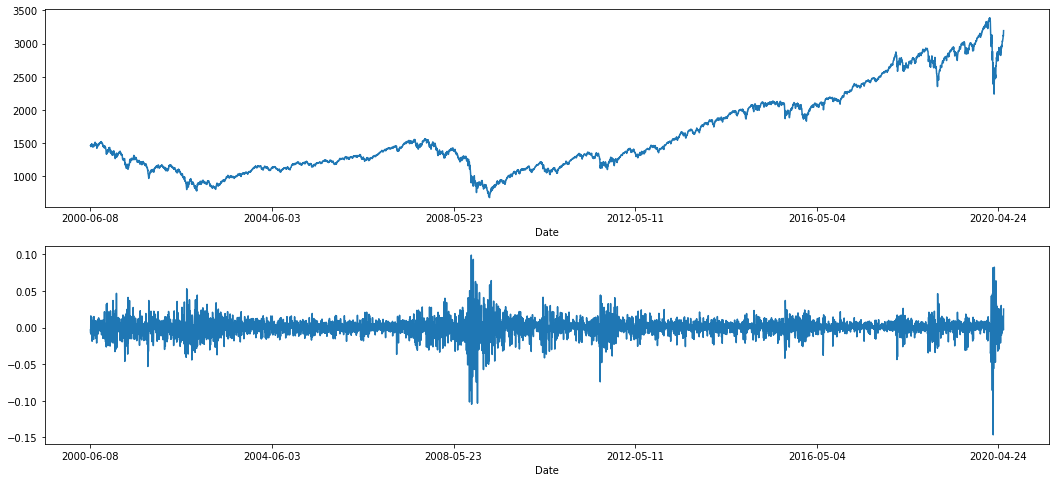

In [35]:
fig, ax = plt.subplots(2,1)
plt1 = SPXHistData["Adj_Close"].plot(ax=ax[0], figsize = (18,8))
plt2 = SPXHistData["LogRtn"].plot(ax=ax[1], figsize = (18,8), y='Value')

La série temporelle des rendements logarithmiques semble visuellement stationnaire, avec une moyenne semblant être égale à 0. L’hétéroscédasticité conditionnelle peut être observée au vue des périodes de fortes volatilités, lors de la crise de 2008, en 2011, puis de 2018 à 2019 où la volatilité est la plus forte au vu des évènement récents, puis du reste des périodes qui sont de faibles volatilités. Ainsi, sans surprise, la série semble pouvoir être modélisée par un modèle GARCH, comme pour la grande majorité des rendements financiers, sous réserve de validation des tests statistiques.

En effet, afin de vérifier si la série présente ce phénomène de volatilité hétéroscédastique, il convient d'effectuer le test d'Engle dont l'hypothèse nulle est l'absence d'effets ARCH :

In [36]:
# Définition de la série temporelle des rendements, sachant que la première valeur est manquante
SPXLogReturns = SPXHistData["LogRtn"].iloc[1:]

# Test d'Engle
results = sm.stats.diagnostic.het_arch(SPXLogReturns)
stat = results[0]
p = results[1]

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interprétation
alpha = 0.05
if p > alpha:
    print("Pas d'effet ARCH sur les résidus")
else:
    print("présence d'effet ARCH sur les résidus")

Statistics=1601.494, p=0.000
présence d'effet ARCH sur les résidus


C:\Users\Si Dan\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:625: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


Ainsi, il est possible de confirmer la présence d'hétéroscédasticité conditionnelle concernant la série temporelle des log-rendements du S&P500, permettant ainsi sa modélisation grâce à un modèle GARCH(1,1).

NB : la bonne pratique exige que des tests statistiques soient réalisées afin d'étudier la présence ou non d'autocorrélation dans la série temporelle. En théorie, les séries temporelles de volatilités historiques ont une moyenne constante proche de zéro, et s'apparentent donc à un bruit blanc, rendant donc inutile une modélisation supplémentaire via un modèle AR (Autorégressif). Cependant, la réalité est souvent autre, poussant ainsi les practitiens à considérer un modèle AR-GARCH. Mais afin de ne pas complexifier le modèle plus que nécessaire, l'absence d'autorégression sera admise. Cette démarche est d'autant plus appuyé par le fait que la moyenne conditionnelle des log-rendements, qui est modélisé par un modèle AR, n'intervient pas dans le calcul du prix des swaps de variance.

Par ailleurs, il convient de vérifier statistiquement la stationarité de la série :

In [37]:
results = sm.tsa.stattools.adfuller(SPXLogReturns)
stat = results[0]
p = results[1]

print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interprétation
alpha = 0.05
if p > alpha:
    print("La série n'est pas stationnaire")
else:
    print("La série est stationnaire")

Statistics=-16.004, p=0.000
La série est stationnaire


Nous pouvons ainsi constater que la série est stationnaire, confirmant ainsi la possibilité de modéliser la série par un modèle GARCH :

#### Modélisation de la volatilité historique du S&P500 par un modèle GARCH(1,1)

La volatilité historique du S&P500 sera modélisé par un modèle GARCH(1,1), en considérant des résidus $\epsilon_n$ de loi normale centrée réduite comme cela a été convenu dans la définition du modèle :

In [38]:
from arch import arch_model

residuals = pd.DataFrame(SPXLogReturns)
# define model
model_arch = arch_model(residuals, vol='GARCH', p=1, q=1, dist='normal')
model_arch_fit = model_arch.fit(update_freq=5)
model_arch_fit.summary()

Iteration:      5,   Func. Count:     66,   Neg. LLF: -6998.874507430878
Iteration:     10,   Func. Count:    137,   Neg. LLF: -5575.699309008312
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5575.699244010901
            Iterations: 14
            Function evaluations: 137
            Gradient evaluations: 10


C:\Users\Si Dan\anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001581. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 LogRtn   R-squared:                     -37.951
Mean Model:             Constant Mean   Adj. R-squared:                -37.951
Vol Model:                      GARCH   Log-Likelihood:                5575.70
Distribution:                  Normal   AIC:                          -11143.4
Method:            Maximum Likelihood   BIC:                          -11117.3
                                        No. Observations:                 5029
Date:                Thu, Jun 18 2020   Df Residuals:                     5025
Time:                        15:03:01   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0775  1.802e-03     42.983      0.000 [7.392e-02,8.098e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1679e-06  3.836e-05  8.258e-02      0.934 [-7.202e-05,7.836e-05]
alpha[1]       0.1001  1.019e-02      9.822  9.022e-23    [8.009e-02,  0.120]
beta[1]        0.8796  1.078e-02     81.592      0.000      [  0.859,  0.901]
=============================================================================

Covariance estimator: robust
"""

#### Modélisation de la volatilité historique du S&P500 par un modèle GARCH(1,1)

Afin de conclure si le modèle GARCH a été capable de modéliser correctement la volatilité historique, Il convient de vérifier si les résidus corrigés de la volatilité du modèle GARCH présentent de l'hétéroscédasticité conditionnel ou non.

Les résidus de la volatilités sont les résidus GARCH auquels on la divise par la volatilité conditionnelle estimée par le modèle. Le test d'Engle est de ce fait effectué sur ces résidus corrigés :

In [39]:
corrected_GARCH_residuals = model_arch_fit.resid/model_arch_fit.conditional_volatility

# Test d'Engle
results = sm.stats.diagnostic.het_arch(corrected_GARCH_residuals)
stat = results[0]
p = results[1]

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interprétation
alpha = 0.05
if p > alpha:
    print("Pas d'effet ARCH sur les résidus corrigés")
else:
    print("présence d'effet ARCH sur les résidus corrigés")

Statistics=225.821, p=0.000
présence d'effet ARCH sur les résidus corrigés


C:\Users\Si Dan\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:625: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


Malhereusement, il persiste sur les résidus corrigés une présence d'effet ARCH, au vu du test statistique d'Engle témoignant ainsi de l'invalidité du modèle GARCH(1,1) nouvellement modélisé. Cependant, il a été décidé d'admettre que le modèle est valable puisque la modélisation par un GARCH(1,1) est le cas d'école le plus fréquent pour les séries financières, incluant le S&P500. Le modèle GARCH approprié à la volatilité historique du S&P500 au vu des résultats de l'estimation est donc défini comme suit :

$$
\left\{
    \begin{array}{lll}
    log(\frac{S_n}{S_{n-1}}) = r_n = 0.0775 + u_n \\
    u_n = \sqrt{v_n} \epsilon_n, \ \epsilon_n \sim \mathcal{N}(0,1) \\
    v_{n+1} = 3.1679*10^{-6} + 0.1001*u_n^2 + 0.8796*v_n
    \end{array}
\right.
$$

De ce fait, les paramètres optimaux du modèle GARCH sont :

- $\hat{\alpha} = 0.1001$
- $\hat{\beta} = 0.8796$
- $\hat{\omega} = (1 - \hat{\alpha} - \hat{\beta})\hat{V} = 3.1679*10^{-6}$ c'est à dire $\hat{V} = 1.56054*10^{-4}$

Ainsi, les paramètres constituant l'équation différentielle stochastique de la variance instantanée en temps continue peuvent être calculés grâce aux formules :

- $\theta = \frac{V}{dt}$
- $\kappa = \frac{1 - \alpha - \beta}{dt}$
- $\sigma_v = \alpha \sqrt{\frac{\xi - 1}{dt}}$

Ici, le rendement étant journalier, $dt = 1j$ ce qui fait que : $dt = 1/360$

In [40]:
alpha = 0.1001
beta = 0.8796
V = 1.56054*10**(-4)
dt = 1/360
xi = SPXLogReturns.kurtosis()

# Calcul des paramètres de l'EDS de la variance instantanée
theta = V/dt
kappa = (1-alpha - beta)/dt
sigma_v = alpha*math.sqrt((xi - 1)/dt)

print("les paramètres calibrés de l'EDS sont : kappa = %f, theta = %f, sigma_v = %f" % (kappa, theta, sigma_v))

les paramètres calibrés de l'EDS sont : kappa = 7.308000, theta = 0.056179, sigma_v = 6.674876


De ce fait, les paramètres issues de la calibration du modèle et qui seront utilisés pour le traçage de la structure à terme du swap de variance sont :

$$
\kappa = 7.3,\ \theta = 0.056179,\ \sigma_v = 6.674876,\ V = 1.56054*10^{-4}
$$

De ce fait, en utilisant les maturités des options sur S&P500, les nouvelles données sont créées, sachant que le prix actuel d'un Variance Swap sur S&P500 est égal à :

$$
(\sigma_0^T)^2  = \theta + (V - \theta)\frac{1-e^{-\kappa T}}{\kappa T}
$$

In [41]:
theta = 0.056179
kappa = 7.3
sigma_v = 6.674876
V = 1.56054*10**(-4)

#Maturity = CallPriceSPX["Maturity"].unique()
Maturity = np.linspace(0.001,2.6,10000)
n = len(Maturity)

Index = [i for i in range(n)]
GARCHVSPrice = pd.DataFrame(index = Index)

GARCHVSPrice['Maturity'] = Maturity

GARCHVS_Price = []
for T in Maturity :
    GARCHVS_Price.append(theta + (V - theta)*((1-math.exp(-kappa*T))/(kappa*T)))

GARCHVSPrice['GARCHFairVariance'] = GARCHVS_Price

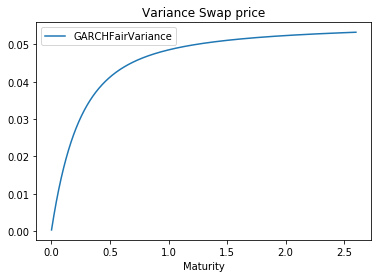

In [42]:
# On définit un dataframe contenant le prix des Variance Swap selon la maturité
GARCH_VSPrice = GARCHVSPrice[['Maturity', 'GARCHFairVariance']].set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
GARCH_VSPrice.plot(title = 'Variance Swap price')

# Paramétrisation de la variance forward instantanée initiale $\xi_0^t$

Il convient dans un premier temps de paramétrer le processus de variance forward instantanée initiale $\xi_0^t$ pour tout $t$. En général, ce processus peut être fixé, ou comme établi dans l'énoncé : paramétré de manière à fitter exactement le future VIX du marché. Cependant, il est possible de procéder autrement :

Pour cela, sachant que l'on souhaite calibrer le modèle pour valoriser des options sur l'indice du S&P500, considérons la 'fair variance' d'un Variance Swap sur S&P500, de maturité $t$, nommée $(\hat{\sigma}_0^t)^2 $. Il est possible d'exprimer cette quantité en fonction du processus de variance forward instantanée initiale comme suit :

$$
(\hat{\sigma}_0^t)^2 = \frac{1}{t} \int_0^t \xi_0^u du
$$

En effet, la 'fair variance' d'un Variance Swap est un pari sur la valeur future de la variance réalisé de l'actif $S$ à maturité $T$. Il s'agit ainsi de la valeur espérée de la variance que va réaliser l'actif $S$ à la maturité $T$, c'est à dire la valeur forward de la variance totale réalisée. 

Plus quantitativement, en posant $\mathbb{Q}$ la probabilité risque neutre, il a été vu précédemment que la 'fair variance' avait pour expression :

$$
(\hat{\sigma}_0^t)^2 = \mathbb{E}^{\mathbb{Q}}[\frac{1}{t} \int_0^t \sigma_u du]
$$

C'est à dire d'après le théorème de Fubini-Tonelli :

$$
(\hat{\sigma}_0^t)^2 = \frac{1}{t} \int_0^t \mathbb{E}^{\mathbb{Q}}[\sigma_u]du
$$

Or en l'absence d'opportunité d'arbitrage, pour $u \in [0,t]$ la variance forward instantanée initiale peut être exprimée comme suit :

$$
\xi_0^u = \mathbb{E}^{\mathbb{Q}}[\sigma_u]
$$

C'est ainsi que naturellement :

$$
(\hat{\sigma}_0^t)^2 = \frac{1}{t} \int_0^t \xi_0^u du
$$

Par la suite , par dérivation des deux membres de l'égalité :

$$
\xi_0^t = \frac{d}{dt}(\hat{\sigma}_0^t)^2 t)
$$

Le processus $\hat{\sigma}_0^t$ de volatilité de Variance Swap du S&P500 de maturité $t$ peut être observé sur le marché. Par ailleurs, il peut être caractérisé par un schéma $w(x)$ de paramétrisation de la structure à terme de la courbe de variance swap :

$$
\hat{\sigma}_0^t = z_1 + w(x)
$$

La paramétrisation doit faire en sorte que la volatilité du Variance Swap puisse tendre vers une constante à long terme, et non diverger. De ce fait, la paramétrisation choisie est de type linearly mean-reverting, signifiant que la volatilité du Variance Swap devrait converger à long terme vers sa moyenne :

$$
\hat{\sigma}_0^t = z_2 + (z_1-z_2)e^{-z_3t}
$$

avec $z_1 \geq 0$ et $z_2, z_3 > 0$, où $z_1,z_2,z_3$ sont respectivement la variance court-terme (short run), la variance long-terme (long-term), et enfin la vitesse de retour à la moyenne. La paramétrisation de la volatilité revient à trouver les paramètres $z_1,z_2,z_3$ optimaux. En posant $\theta = \{z_1,z_2,z_3\}$ et $f(\theta,t) = z_2 + (z_1-z_2)e^{-z_3t}$, le problème de minimisation associé est donc :

$$
\theta_{opt} = argmin_{\Theta}\sum_T (\hat{\sigma}_0^T - f(\theta,T))^2
$$

Ainsi, la courbe de variance forward instantanée initiale $\xi_0^t$ est calculée en dérivant $(\hat{\sigma}_0^t)^2 t = (z_2 + (z_1-z_2)e^{-z_3t})^2 t$ par rapport à $t$. Cette dérivation donne l'expression de $\xi_0^t$ :

$$
\xi_0^t = z_2^2 + (z_1 - z_2)[2z_2(1 - z_3 t)e^{-z_3t} + (1-2tz_3) e^{-2z_3t}]
$$

$$
\xi_0^t = (z_2 + (z_1-z_2)e^{-z_3t})^2 -2tz_3(z_1-z_2)e^{-z_3t}(z_2 + (z_1-z_2)e^{-z_3t})
$$

De ce fait la calibration peut être implémentée :

In [43]:
def f(z1,z2,z3,t):
    return z2 + (z1 - z2)*math.exp(-z3*t)

def MeanRevertingScheme(*params):
    z1, z2, z3 = params
    n = len(GARCHVSPrice)
    T = GARCHVSPrice["Maturity"].unique()
    GARCHFairVariance = GARCHVSPrice["GARCHFairVariance"]
    FairVarMeanReverting =[0 for i in range(n)]
    for i in range(n):
        FairVarMeanReverting[i] = f(z1,z2,z3,T[i])
    residuals = np.power((GARCHFairVariance - FairVarMeanReverting),2)
    OLS = np.sum(residuals)
    return OLS

In [44]:
optimize_function = lambda params :  MeanRevertingScheme(*params)
param_initiaux = [0,0,1]
Theta_Opt = spop.fmin(optimize_function, param_initiaux, maxiter=1000, maxfun=1000)

Optimization terminated successfully.
         Current function value: 0.007028
         Iterations: 117
         Function evaluations: 209


In [45]:
(z1,z2,z3) = Theta_Opt
print("les paramètres calibrés sont : z1 = %f, z2 = %f, z3 = %f" % (z1,z2,z3))

les paramètres calibrés sont : z1 = 0.003784, z2 = 0.052034, z3 = 2.969990


Ainsi, il est possible de tracer le prix actuel des Variance Swap grâce à la paramétrisation de type linearly mean-reversion ainsi que celui établie par le modèle GARCH que l'on considère être celui du marché, afin de les comparer et juger la qualité de la calibration :

Text(0.5, 1.0, 'Comparison of Variance Swap Price')

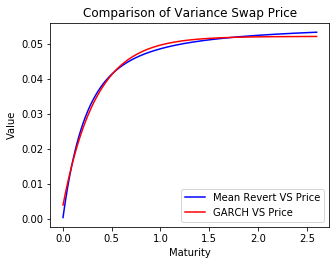

In [46]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
GARCH_VSPrice = GARCHVSPrice[['Maturity', 'GARCHFairVariance']].sort_values('Maturity')

# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
Maturity = GARCH_VSPrice['Maturity']
(z1,z2,z3) = Theta_Opt
VS_MeanRevert = [f(z1,z2,z3,t) for t in Maturity]

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(GARCHVSPrice['Maturity'],GARCH_VSPrice['GARCHFairVariance'], color = 'b', label = 'Mean Revert VS Price')
plt.plot(GARCHVSPrice['Maturity'],VS_MeanRevert , color = 'r', label = 'GARCH VS Price')
plt.xlabel('Maturity')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison of Variance Swap Price')

Les courbes du prix des Variance Swaps selon les deux méthodes sont fortement similaire, témoignant ainsi de la bonne qualité de la calibration selon cette paramétrisation mean-reversion.

De ce fait, la dérivée de la fonction $f^2(z_1,z_2,z_3,t)t$ par rapport au temps $t$ peut être implémentée :

In [47]:
def derivative(z1,z2,z3,t):
    return (z2 + (z1-z2)*math.exp(-z3*t))**2 -2*t*z3*(z1-z2)*math.exp(-z3*t)*(z2 + (z1-z2)*math.exp(-z3*t))

Et la variance forward instantanée initiale selon cette paramétrisation peut être calculée afin de la tracer :

In [48]:
n = len(GARCH_VSPrice)
Maturity = GARCH_VSPrice['Maturity'].iloc[1:n-1]
(z1,z2,z3) = Theta_Opt
InitialVar_Forward_MeanRevert = [derivative(z1,z2,z3,t) for t in Maturity]

Une autre possibilité est d'estimer numériquement $\xi_0^t$ par différence finies la dérivée de $\hat{\sigma}_0^t$ grâce aux données du marchés pour tout instant $t$: 

$$
\xi_0^t = (\hat{\sigma}_0^t)^2 + t\frac{(\hat{\sigma}_0^{t+\Delta})^2-(\hat{\sigma}_0^{t-\Delta})^2}{2\Delta}
$$

Avec $\Delta$ le pas de temps.

In [49]:
n = len(GARCHVSPrice)
Index = [i for i in range(1,n-1)]
InitialVarForward = pd.DataFrame(index = Index)
InitialVarForward['Maturity'] = Maturity[1:n-1]
xi_0T = []
for i in range(1,n-1):
    Delta = GARCHVSPrice['Maturity'].iloc[i+1] - GARCHVSPrice['Maturity'].iloc[i-1]
    xi_0T.append((GARCHVSPrice['GARCHFairVariance'].iloc[i])**2 + GARCHVSPrice['Maturity'].iloc[i]*0.5*((GARCHVSPrice['GARCHFairVariance'].iloc[i+1])**2 - (GARCHVSPrice['GARCHFairVariance'].iloc[i-1])**2)/Delta)

InitialVarForward['Value'] = xi_0T

Ainsi, il est possible de comparer les deux approches en traçant leur variance forward instantanée initiale par rapport à chaque maturité : 

Text(0.5, 1.0, 'Comparison of Initial Variance Forward')

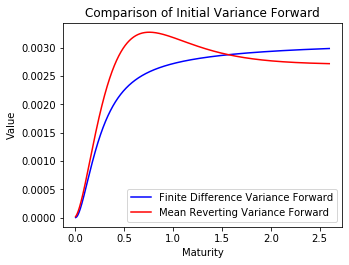

In [50]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
InitialVar_Forward_FiniteDiff = InitialVarForward[['Maturity', 'Value']].sort_values('Maturity')

# On définit un dataframe contenant la variance forward instantanée initiale selon la paramétrisation mean-reverting
Maturity = InitialVar_Forward_FiniteDiff['Maturity']

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(InitialVar_Forward_FiniteDiff['Maturity'],InitialVar_Forward_FiniteDiff['Value'], color = 'b', label = 'Finite Difference Variance Forward')
plt.plot(InitialVar_Forward_FiniteDiff['Maturity'],InitialVar_Forward_MeanRevert , color = 'r', label = 'Mean Reverting Variance Forward')
plt.xlabel('Maturity')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison of Initial Variance Forward')

Il est ainsi possible de constater que les courbes de variance forward instantanées initiales semblent assez similaires, malgré un retour à la moyenne long terme de la variance plus rapide concernant la courbe issue de la paramétrisation. D'après les résultats trouvées dans la littérature, ce type de courbe est réaliste et typique des courbes de variances forward, d'autant plus que celle issue de la méthode des différences finies n'est qu'une approximation numérique, dépendant fortement du pas de temps utilisé et qui est moins précise dans plusieurs cas de figures par rapport à l'approche paramétrique via une formule close.

C'est ainsi que la courbe de variance forward instantanée initiale issue de la paramétrisation linearly mean-reverting sera exploitée dans la calibration du modèle de Bergomi.

Ainsi, une fois la paramétrisation du processus $\xi_0^t$ terminée, il est possible de calibrer l'ensemble des paramètres $\Theta = \{\omega, \gamma, k_1, k_2, \rho_1, \rho_2, \rho_{12}\}$. Pour cela, la démarche est la suivante, en commançant par la définition de la volatilité instantanée de la volatilité du Variance Swap et la calibration via ce processus :

### Calibration via la volatilité instantanée de la volatilité d'un Swap de variance

Pour la calibration du modèle de Bergomi, il sera supposé ici que 

Considérons une fois de plus le prix à l'instant $t$ (ou 'fair variance') d'un Swap de variance de l'indice du S&P500 de maturité $T$, nommée $\hat{\sigma}_t^T$, tel que :

$$
(\hat{\sigma}_t^T)^2 = \frac{1}{T-t} \int_t^T\xi_t^u du
$$

Or la dynamique de $\xi_t^T$ sous le modèle de Bergomi à deux facteurs est donnée par :

$$
d\xi_t^T = \omega \alpha_{\gamma} \xi_t^T [(1-\gamma)e^{-k_1 (T-t)}dW_t^1 + \gamma e^{-k_2 (T-t)}dW_t^2]
$$

avec $\alpha_{\gamma} = 1/\sqrt{(1-\gamma)^2 + \gamma^2 + 2\rho_{12}\gamma(1-\gamma)}$ le facteur de normalisation.

La formule de Leibnitz appliquée à $\frac{1}{T-t} \int_t^T\xi_t^u du$ permet d'établir la dynamique de $(\hat{\sigma}_t^T)^2 $ :

$$
d(\hat{\sigma}_t^T)^2 = \frac{1}{T-t}d(\int_t^T\xi_t^u du) = \frac{1}{T-t}(\int_t^T d\xi_t^u du - \xi_t^t dt)
$$

De ce fait, et en appliquant le lemme de Fubini, 

$$
d(\hat{\sigma}_t^T)^2 = \frac{1}{T-t} \omega \alpha_{\gamma} [(1-\gamma)(\int_t^T \xi_t^u e^{-k_1 (u-t)}du )dW_t^1 + \gamma (\int_t^T \xi_t^u e^{-k_2 (u-t)}du) dW_t^2] - \frac{1}{T-t}\xi_t^t dt
$$

Enfin, la formule d'Itô appliquée à $\hat{\sigma}_t^T = \sqrt{(\hat{\sigma}_t^T)^2} = f((\hat{\sigma}_t^T)^2)$ permet d'établir sa dynamique :

$$
d\hat{\sigma}_t^T = \frac{1}{2\sqrt{(\hat{\sigma}_t^T)^2}} d(\hat{\sigma}_t^T)^2 - \frac{1}{2}\frac{1}{4(\hat{\sigma}_t^T)^3} d<(\hat{\sigma}_t^T)^2> = \frac{\hat{\sigma}_t^T}{2(\hat{\sigma}_t^T)^2} d(\hat{\sigma}_t^T)^2 - \frac{1}{2}\frac{1}{4(\hat{\sigma}_t^T)^3} d<(\hat{\sigma}_t^T)^2>
$$

De ce fait, sachant que $(\hat{\sigma}_t^T)^2 = \frac{1}{T-t} \int_t^T\xi_t^u du$ et en ne tenant pas compte du drift, il est possible d'obtenir la dynamique de $\hat{\sigma}_t^T$ :

$$
\frac{d\hat{\sigma}_t^T}{\hat{\sigma}_t^T} = \frac{\omega \alpha_{\gamma}}{2} [(1 - \gamma) \frac{\int_t^T\xi_t^u e^{-k_1 (u-t)} du}{\int_t^T\xi_t^u du}dW_t^1 + \gamma \frac{\int_t^T\xi_t^u e^{-k_2 (u-t)} du}{\int_t^T\xi_t^u du}dW_t^2] + (...)dt
$$

En posant pour $i = 1,2$ : $A_i = \frac{\int_t^T\xi_t^u e^{-k_i (u-t)} du}{\int_t^T\xi_t^u du}$, cette dynamique devient :

$$
\frac{d\hat{\sigma}_t^T}{\hat{\sigma}_t^T} = \frac{\omega \alpha_{\gamma}}{2} [(1 - \gamma) A_1dW_1^T + \gamma A_2dW_2^T] + (...)dt
$$

Dans le cas d'une structure à terme de la 'fair volatility' des Variance Swap dite'flat', la variance forward instantanée $\xi_t^T$ ne dépend pas de $T$ et donc que $\xi_0^T$ est constante égale à $\sigma_0^2$. Cela implique donc que pour $i = 1,2$ :

$$
A_i = \frac{1- e^{-k_i(T-t)}}{k_i(T-t)}
$$ 

De ce fait, il est possible d'introduire la volatilité instantanée $\nu_t^T$ de la volatilité du swap de variance $\hat{\sigma}_t^T$, en prenant en compte le fait que les mouvement browniens $W_t^1$ et $W_t^2$ sont décorrélés :

Sachant $\nu_t^T$ est exprimée telle que :

$$
\frac{d<\hat{\sigma}^T>_t}{(\hat{\sigma}_t^T)^2} = (\nu_t^T)^2dt
$$

Alors le processus peut être exprimé comme suit :

$$
\nu_t^T = \frac{\omega \alpha_{\gamma}}{2} \sqrt{(1 - \gamma)^2 A_1^2 + \gamma^2 A_2^2 + 2\rho_{12}\gamma (1-\gamma)A_1 A_2}
$$

Par ailleurs, la volatilité instantanée de la volatilité d'un swap de variance de maturité $T$ peut être mesurée empiriquement comme l'écart type du rendement logarithmique annualisé de la volatilité du Variance Swap du S&P500 de maturité $T$:

$$
Vol(\hat{\sigma}_0^{T})^2 = \frac{1}{n-2}\sum_{i=1}^{n-1} (log(\hat{\sigma}_{0,i+1}^{T}/\hat{\sigma}_{0,i}^{T}) - \frac{1}{n-1} \sum_{i=1}^{n-1} log(\hat{\sigma}_{0,i+1}^{T}/\hat{\sigma}_{0,i}^{T}))^2 * 252
$$

avec $n$ le nombre d'observations provenant des données du Variance Swap.

De ce fait, il est possible de calibrer les paramètres $\Theta = \{\omega, \gamma, k_1, k_2, \rho_{12}\} $ en minimisant l'erreur quadratique de la volatilité instantanée :

$$
\Theta_{opt} = argmin_{\Theta}\sum_T (\nu_0^T - Vol(\hat{\sigma}_0^{T}))^2
$$

#### Expression de la volatilité de la volatilité du Variance Swap sous le modèle GARCH

Sachant que le prix du Swap de Variance sur le S&P500 a été simulé pour chaque maturité selon le modèle GARCH, il convient d'exprimer sa volatilité instantanée sous ce même modèle. 

il convient de se rappeler que sous ce modèle, le prix actuel d'un variance swap est donné par

$$
(\sigma_0^T)^2  = \theta + (V - \theta)\frac{1-e^{-\kappa T}}{\kappa T}
$$

Et plus généralement pour tout instant $t$ :

$$
(\sigma_t^T)^2  = \theta + (v_t - \theta)\frac{1-e^{-\kappa (T-t)}}{\kappa (T-t)}
$$

Et sa dynamique, sans prendre en compte son drift étant donné que l'on souhaite exprimer une volatilité instantanée, est donnée par :

$$
d(\sigma_t^T)^2  = (...)dt + \frac{1-e^{-\kappa (T-t)}}{\kappa (T-t)} \sigma_v v_t dW_t^2
$$

puisque la dynamique de la variance instantanée est donnée par :

$$
dv_t = \kappa(\theta - v_t) dt + \sigma_v v_t dW_t^2 
$$

La formule d'Itô appliquée à $\hat{\sigma}_t^T = \sqrt{(\hat{\sigma}_t^T)^2} = f((\hat{\sigma}_t^T)^2)$ permettant d'établir sa dynamique :

$$
d\hat{\sigma}_t^T = \frac{\sqrt{(\hat{\sigma}_t^T)^2}}{2(\hat{\sigma}_t^T)^2} d(\hat{\sigma}_t^T)^2 - \frac{1}{2}\frac{1}{4(\hat{\sigma}_t^T)^3} d<(\hat{\sigma}_t^T)^2> = \frac{\hat{\sigma}_t^T}{2(\hat{\sigma}_t^T)^2} d(\hat{\sigma}_t^T)^2 - \frac{1}{2}\frac{1}{4(\hat{\sigma}_t^T)^3} d<(\hat{\sigma}_t^T)^2>
$$

Nous obtenons finalement :

$$
\frac{d\hat{\sigma}_t^T}{\hat{\sigma}_t^T} = \frac{1}{(\hat{\sigma}_t^T)^2} \frac{1-e^{-\kappa (T-t)}}{\kappa (T-t)} \sigma_v v_t dW_t^2 + (...)dt
$$

Et la volatilité instantanée $\nu_t^T$ de $\hat{\sigma}_t^T$, une fois de plus exprimée telle que :

$$
\frac{d<\hat{\sigma}^T>_t}{(\hat{\sigma}_t^T)^2} = (\nu_t^T)^2dt
$$

a pour expression : 

$$
\nu_t^T = \frac{1}{2(\hat{\sigma}_t^T)^2} \frac{1-e^{-\kappa (T-t)}}{\kappa (T-t)} \sigma_v v_t
$$

De ce fait, à l'instant 0, 

$$
Vol(\hat{\sigma}_0^T) = \frac{1}{2(\hat{\sigma}_0^T)^2} \frac{1-e^{-\kappa T}}{\kappa T} \sigma_v v_0 = \frac{1}{2(\hat{\sigma}_0^T)^2} \frac{1-e^{-\kappa T}}{\kappa T} \sigma_v V
$$

avec $\kappa$, $\sigma_v$ et $V$ les paramètres de Heston qui ont été préalablement calibrés aux données.

Les données de la volatilité de la volatilité $Vol(\hat{\sigma}_0^T)$ peuvent donc être implémentées pour chaque maturité :

In [51]:
theta = 0.056179
kappa = 7.3
sigma_v = 6.674876
V = 1.56054*10**(-4)

#Maturity = CallPriceSPX["Maturity"].unique()
Maturity = np.linspace(0.001,2.6,10000)
n = len(Maturity)

Index = [i for i in range(n)]
GARCHVolVSvol = pd.DataFrame(index = Index)

GARCHVolVSvol['Maturity'] = Maturity

VolVS_vol = []
for i in range(n) :
    VolVS_vol.append((1/(2*(GARCHVSPrice['GARCHFairVariance'].iloc[i])**2))*((1-math.exp(-kappa*GARCHVSPrice['Maturity'].iloc[i]))/(kappa*GARCHVSPrice['Maturity'].iloc[i]))*sigma_v*V)
    #if Maturity[i] <= (1/kappa) :
        #VolVS_vol.append(1 - 0.5*kappa*Maturity[i])
    #else :
        #VolVS_vol.append(1/(kappa*Maturity[i]))
GARCHVolVSvol['Vol_Of_VSVol'] = VolVS_vol

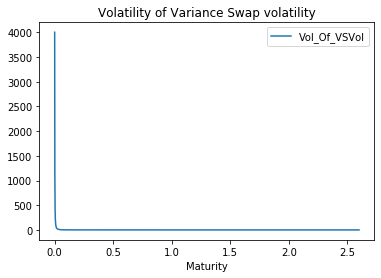

In [52]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
GARCH_VolVSvol = GARCHVolVSvol[['Maturity', 'Vol_Of_VSVol']].set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
GARCH_VolVSvol.plot(title = 'Volatility of Variance Swap volatility')

Malheureusement, les données concernant la volatilité de la volatilité des Variance Swaps sur S&P500 sont aberrants, témoignant d'une incohérence dans les paramètres estimés par le modèle GARCH. Ainsi, une solution sera prise ultérieurement pour obtenir des données cohérentes concernant cette quantité, pour la calibration des paramètres du modèle de Bergomi à deux facteurs.

La deuxième quantité à considérer pour la calibration du modèle est le Skew ATMF des options sur S&P500.

### Expression du Skew At the Money Forward ATMF à maturité $T$ sous le modèle de Bergomi

La volatilité At the Money Forward est la volatilité implicite des options sur S&P500 dont le prix forward du sous jacent qui est l'indice, est égal au Strike $K$. La volatilité ATMF peut dont directement être observé sur le marché en retenant la volatilité implicite des options dont le strike $K = F_T$ avec $F_T$ la valeur forward du S&P500 à l'instant future $T$. Ce Skew du marché est nommé $S_T^{mkt}$.

De ce fait, il est possible d'introduire le Skew At the Money forward $S_T$ dont la formule est la suivante, en fonction de la volatilité implicite des options sur S&P500 $\hat{\sigma}_{K,T}^{imp}$ dépendant du Strike $K$ et de la maturité $T$:

$$
S_T = \frac{d\hat{\sigma}_{K,T}^{imp}}{dln(K)}|_{F_T}
$$

Cette quantité provient d'un développement limité au voisinage de $ln(F_T)$ de la volatilité implicite $\hat{\sigma}_{K,T}^{imp}$ que l'on considère comme une fonction de $ln(K)$ :

$$
\hat{\sigma}_{K,T}^{imp} = \hat{\sigma}_{F_T,T}^{imp} + S_T ln(\frac{K}{F_T}) + C_T ln^2(\frac{K}{F_T}) + O(\epsilon^3)
$$

avec $S_T$ le Skew ATMF, et $C_T$ la Curvature ATMF, qui sont les dérivés première et seconde de la volatilité implicite par rapport à la variable $ln(K)$.

Ainsi, le skew ATMF peut être empiriquement calculé grâce aux données du marchés, par exemple en estimant que la différence entre la volatilité implicite des options de Strike $0.95F_T$ et celle de Strike $1.05F_T$ est approximativement égale à $-0.1S_T$, $S_T$ étant le skew ATMF :

$$
S_T = -\frac{\hat{\sigma}_{0.95F_T,T}^{imp} - \hat{\sigma}_{1.05F_T,T}^{imp}}{0.1} = -10*(\hat{\sigma}_{0.95F_T,T}^{imp} - \hat{\sigma}_{1.05F_T,T}^{imp})
$$

Par ailleurs, Bergomi et Guyon ont été capable d'obtenir une expression du Skew ATMF à maturité $T$, nommé $S_T$. Sans rentrer dans les détails des calcus, ces derniers ont pu l'approximer au premier ordre dans le cas du modèle de Bergomi à deux facteurs de manière suivante :

$$
S_T^{order \ 1} = \frac{\omega \alpha_{\gamma}}{2(\hat{\sigma}^T)^3T^2} \int_0^Tdt \sqrt{\xi_0^t} \int_t^T(\xi_0^u[(1-\gamma)\rho_1e^{-k_1(u-t)} + \gamma \rho_2 e^{-k_1(u-t)}]du
$$

avec $\alpha_{\gamma} = 1/\sqrt{(1-\gamma)^2 + \gamma^2 + 2\rho_{12}\gamma (1-\gamma)}$

avec $\hat{\sigma}^T = \sqrt{\frac{1}{T}\int_0^T \xi_0^t dt}$. Et dans le cas d'une structure à terme 'flat' des variances forward ou des volatilités de Variance Swap qui est l'hypothèse de départ pour la calibration, l'expression précédente peut être simplifiée comme suit :

$$
S_T^{order \ 1} =\frac{\omega \alpha_{\gamma}}{2}[(1-\gamma)\rho_1\frac{k_1T - (1-e^{-k_1T})}{(k_1T)^2} + \gamma \rho_2\frac{k_2T - (1-e^{-k_2T})}{(k_2T)^2}]
$$

avec $\rho_1$ et $\rho_2$ les paramètres de corrélations issue d'un modèle à volatilité stochastique log-normale.

Ainsi, le skew ATMF pouvant être observé sur le marché, les paramètres $\rho_1$ et $\rho_2$, et plus généralement aussi les paramètres $\Theta = \{\omega, \gamma, k_1, k_2\} $ peuvent être calibrés via le problème de minimisation des moindres carrés suivant :

$$
\Theta_{opt} = argmin_{\Theta}\sum_T (S_T^{order \ 1} - S_T^{mkt} )^2
$$

Afin de pouvoir effectuer cette calibration, il convient d'appliquer la formule $S_T = -10*(\hat{\sigma}_{0.95F_T,T}^{imp} - \hat{\sigma}_{1.05F_T,T}^{imp})$ afin de recueillir les données du marché concernant le Skew ATMF. Malheureusement, devant l'impossibilité d'obtenir suffisamment d'options dont le Strike est égal à 0.95 ou 1.05 fois le prix forward $F$ pour chaque maturité $T$, il a été convenu de calibrer pour chaque maturité $T$ une surface de volatilité implicite dite SVI sur les données du marché des volatilité implicites des options sur S&P500. Cette surface sera utilisée pour calculer le Skew ATMF du marché.

### Calibration d'une surface de volatilité implicite de type SVI

La paramétrisation d'une surface de volatilité implicite de type Stochastic Volatility Inspired est une méthode paramétrique et non stochastique de la calibration du Smile de volatilité, basée sur les données du marché etsur une formule close de la surface de volatilité. Cette approche a été développée par Merril Lynch en 1999.

Dans un premier temps, on pose $C_{BS}(k, \sigma^2 T)$ le prix Black Scholes d'un Call de Strike $F_t e^{k}$, la maturité étant égale à $T$ et la volatilité égale à $\sigma >0$. De ce fait, la volatilité implicite de Black Scholes est nommée $\sigma_{BS}(k,T)$ et la variance implicite totale est donnée par $w(k,T) = \sigma_{BS}(k,T)^2 T$. Il s'agit de cette dernière quantité dont il faut se baser pour calibrer la surface paramétrique, sachant qu'elle est observable sur le marché grâce aux données de la volatilité implicite de Black Scholes. Ces données seront nommées $w^{Mkt}(k,T)$.

On pose par la suite le set de paramètre $\Theta = \{a,b,\rho,m,\sigma \}$. Bien qu'il y ai plusieurs choix de surface paramétrique, il a été convenu de n'en choisir qu'un seul de manière arbitraire. De ce fait, l'expression de la surface paramétrique utilisée est donnée pour chaque maturité $T$ par :

$$
w^{SVI}(k,\Theta) = a + b\{ \rho (k-m) + \sqrt{(k-m)^2 + \sigma^2} \}
$$

avec $a \in \mathbb{R}$, $b \geq 0$, $|\rho| \leq 1$, $m \in \mathbb{R}$, $\sigma > 0$, et avec la condition $a+b\sigma \sqrt{1-\rho^2} \geq 0$ permettant ainsi de s'assurer que $w^{SVI}(k,\Theta) \geq 0$, pour tout $k$.

De ce fait, la calibration d'une telle surface s'effectue pour chaque maturité $T$ en résolvant le problème de minimisation suivante en respectant les contraintes ci-dessus :

$$
\Theta_{Opt,T} = argmin_{\Theta} \sum_k (w^{SVI}(k,\Theta) - w^{Mkt}(k,T))^2
$$

NB : le set de paramètre $\Theta$ calibré est différent pour chaque maturité.

Sachant que les options sont côtés selon un Strike $K$, et que la quantité $k$ est telle que $K = F_T e^{k}$, alors il est possible d'en déduire que pour chaque Strike $K$ et Maturité $T$, $k = ln(\frac{K}{F_T})$. Et de ce fait, cette variable est dans un premier temps calculé pour toute option :

In [53]:
# on introduit la variable log-strike k dans les jeux de données pour chaque Strike et Maturité des options
n = len(CallPriceSPX)

CallPriceSPX['k'] = [math.log(CallPriceSPX["Strike"].iloc[i]/CallPriceSPX["Forward_SPX"].iloc[i]) for i in range(n)]
PutPriceSPX['k'] = [math.log(PutPriceSPX["Strike"].iloc[i]/PutPriceSPX["Forward_SPX"].iloc[i]) for i in range(n)]

On implémente par la suite la surface paramétrique à calibrer, ainsi que la variance totale des options observée sur le marché :

In [54]:
# définition de la surface paramétrique à calibrer
def wSVI(k, *Theta):
    a,b,rho,m,sigma = Theta
    surface = a + b*(rho*(k-m)+ math.sqrt((k-m)**2 + sigma**2))
    return surface

n = len(CallPriceSPX)
# Calcul de la variance totale du marché pour chaque option
CallPriceSPX['w_Mkt'] = [((CallPriceSPX['IV'].iloc[i])**2)*CallPriceSPX['Maturity'].iloc[i] for i in range(n)]
PutPriceSPX['w_Mkt'] = [((PutPriceSPX['IV'].iloc[i])**2)*PutPriceSPX['Maturity'].iloc[i] for i in range(n)]

Et c'est ainsi que la calibration est effectuée :

In [57]:
from scipy.signal import argrelextrema

# On définit la fonctions de contrainte d'optimisation
def constraint(*Theta) :
    a,b,rho,m,sigma = Theta
    return a + b*sigma*math.sqrt(1- rho**2)

# On définit les conditions aux bords pour chaque variable :
bound_a = (-math.inf, math.inf)
bound_b = (0, math.inf)
bound_rho = (-1,1)
bound_m = (-math.inf, math.inf)
bound_sigma = (0, math.inf)

general_bounds = (bound_a,bound_b,bound_rho,bound_m,bound_sigma)

# On définit la fonction à calibrer
def SVICalibration(exp, *Theta):
    a,b,rho,m,sigma = Theta
    
    # On filtre les données des Calls selon leur date d'expiration
    CallPriceSPX_by_matur = CallPriceSPX[CallPriceSPX['Expiration_Date'] == exp][['Strike','Maturity','IV','k','w_Mkt']]
    
    # On enlève les Calls dont la volatilité implicite est très faible pour améliorer la calibration
    CallPriceSPX_by_matur = CallPriceSPX_by_matur[CallPriceSPX_by_matur['IV'] > 0.03]
    
    # On réindexe correctement les nouveaux jeux de données
    n = len(CallPriceSPX_by_matur)
    CallPriceSPX_by_matur['Index'] =[i for i in range (n)]
    CallPriceSPX_by_matur = CallPriceSPX_by_matur.set_index('Index')
    
    # On considère le Strike et le prix Mid des options et les résidus moindres carrés sont calculés
    k = CallPriceSPX_by_matur["k"]
    w_Mkt = CallPriceSPX_by_matur["w_Mkt"]
    w_SVI = [wSVI(k[i], *Theta) for i in range(n)]
    Residuals = pow(w_SVI - w_Mkt,2)
    OLSResiduals = np.sum(Residuals)
    return OLSResiduals

In [58]:
# extraction de chaque date d'expiration
Expiration = CallPriceSPX["Expiration_Date"].unique()

# Création du vecteur comprenant le discount factor et le prix forward à chaque maturité
SVIParameter = []
for exp in Expiration :
    
    # On définit la contrainte
    constraint_fun = lambda Theta : constraint(*Theta)
    cons = {'type' :'ineq', 'fun' : constraint_fun}
    
    # On redéfinit la fonction d'optimisation en fonction des paramètres
    optimize_function = lambda Theta : SVICalibration(exp,*Theta)
    
    # On initie les paramètres initiaux.
    Theta_initiaux = [0, 0.1, 0.3, 0.3, 0.4]
    
    # On effectue l'optimisation
    ThetaOpti = spop.minimize(optimize_function,Theta_initiaux,method='SLSQP',bounds = general_bounds, constraints = cons)
    
    # On ajoute pour chaque maturité les paramètres calibrés
    SVIParameter.append(ThetaOpti.x)

De ce fait, il convient de créer un jeu de données comprenant l'ensemble des résultats ci dessus, c'est à dire les paramètres permettant de construire la surface paramétrique $w^{SVI}$, et cela en fonction de toutes les maturités existantes $T$ pour les options sur l'indice.

In [59]:
n = len(SVIParameter)

# Pour chaque maturité, on liste chacun des paramètres
a = [SVIParameter[i][0] for i in range(n)]
b = [SVIParameter[i][1] for i in range(n)]
rho = [SVIParameter[i][2] for i in range(n)]
m = [SVIParameter[i][3] for i in range(n)]
sigma = [SVIParameter[i][4] for i in range(n)]

# Création du jeu de données
Index = [i for i in range(n)]
SVIParameterData = pd.DataFrame(index = Index)
SVIParameterData['Expiration_Date'] = Expiration
SVIParameterData['a'] = a
SVIParameterData['b'] = b
SVIParameterData['rho'] = rho
SVIParameterData['m'] = m
SVIParameterData['sigma'] = sigma

Il convient maintenant, afin de pouvoir calculer la surface paramétrique SVI pour chaque Calls, de faire la jointure entre le nouveau jeu de données contenant les paramètres de la surface paramétrique ainsi que celui du prix des options, en fonction de la date d'expiration, qui est considérée comme index pour chacune des jeux de données. Pour cela, on définit le nouvel index pour les deux jeux de données.

In [60]:
CallPriceSPX = CallPriceSPX.set_index("Expiration_Date")
SVIParameterData = SVIParameterData.set_index("Expiration_Date")

In [61]:
# On joint selon une procédure Left Join la table des Calls avec celle du prix du sous-jacent, selon l'index
CallPriceSPX = CallPriceSPX.join(SVIParameterData)

In [62]:
# On réinitialise l'index :
CallPriceSPX = CallPriceSPX.reset_index()
SVIParameterData = SVIParameterData.reset_index()

De ce fait, il est possible de calculer la surface paramétrique SVI pour chaque Call à partir des paramètres calibrés afin de vérifier la calibration :

In [63]:
n = len(CallPriceSPX)
Theta = CallPriceSPX[['a','b','rho','m','sigma']]
k = CallPriceSPX['k']
CallPriceSPX['w_SVI'] = [wSVI(k.iloc[i], *Theta.iloc[i]) for i in range(n)]

Text(0, 0.5, 'Value')

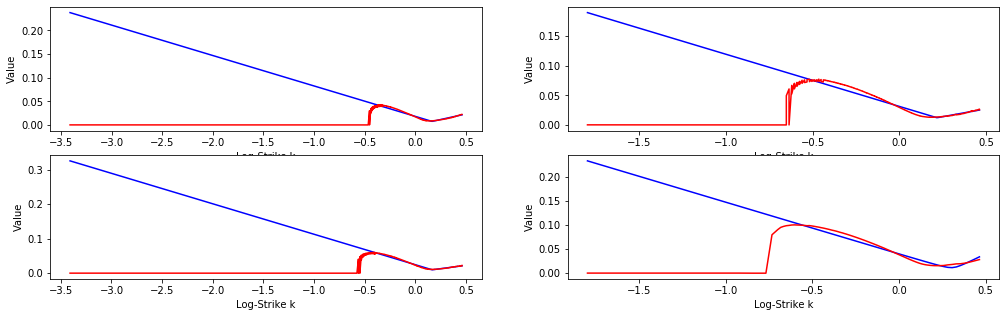

In [64]:
CallPriceSPX_2M = CallPriceSPX[CallPriceSPX['Expiration_Date'] == '2020-08-21']
CallPriceSPX_3M = CallPriceSPX[CallPriceSPX['Expiration_Date'] == '2020-09-18']
CallPriceSPX_4M = CallPriceSPX[CallPriceSPX['Expiration_Date'] == '2020-10-16']
CallPriceSPX_5M = CallPriceSPX[CallPriceSPX['Expiration_Date'] == '2020-11-20']

# On définit un dataframe contenant la surface paramétrique des Calls en fonction du log-strike en indice
SVI_w_2M = CallPriceSPX_2M[['k','w_SVI']].sort_values('k')
SVI_w_3M = CallPriceSPX_3M[['k','w_SVI']].sort_values('k')
SVI_w_4M = CallPriceSPX_4M[['k','w_SVI']].sort_values('k')
SVI_w_5M = CallPriceSPX_5M[['k','w_SVI']].sort_values('k')

# On définit un dataframe contenant la surface paramétrique des Calls en fonction du log-strike en indice
Market_w_2M = CallPriceSPX_2M[['k','w_Mkt']].sort_values('k')
Market_w_3M = CallPriceSPX_3M[['k','w_Mkt']].sort_values('k')
Market_w_4M = CallPriceSPX_4M[['k','w_Mkt']].sort_values('k')
Market_w_5M = CallPriceSPX_5M[['k','w_Mkt']].sort_values('k')

fig, axs = plt.subplots(2,2, figsize = (17,5))

axs[0,0].plot(SVI_w_2M['k'],SVI_w_2M['w_SVI'], color = 'b', label = 'Parametric SVI')
axs[0,0].plot(SVI_w_2M['k'],Market_w_2M['w_Mkt'], color = 'r', label = 'Market SVI')
axs[1,0].plot(SVI_w_3M['k'],SVI_w_3M['w_SVI'], color = 'b', label = 'Parametric SVI')
axs[1,0].plot(SVI_w_3M['k'],Market_w_3M['w_Mkt'], color = 'r', label = 'Market SVI')
axs[0,1].plot(SVI_w_4M['k'],SVI_w_4M['w_SVI'], color = 'b', label = 'Parametric SVI')
axs[0,1].plot(SVI_w_4M['k'],Market_w_4M['w_Mkt'], color = 'r', label = 'Market SVI')
axs[1,1].plot(SVI_w_5M['k'],SVI_w_5M['w_SVI'], color = 'b', label = 'Parametric SVI')
axs[1,1].plot(SVI_w_5M['k'],Market_w_5M['w_Mkt'], color = 'r', label = 'Market SVI')

axs[0,0].set_xlabel('Log-Strike k')
axs[1,0].set_xlabel('Log-Strike k')
axs[0,1].set_xlabel('Log-Strike k')
axs[1,1].set_xlabel('Log-Strike k')

axs[0,0].set_ylabel('Value')
axs[1,0].set_ylabel('Value')
axs[0,1].set_ylabel('Value')
axs[1,1].set_ylabel('Value')
#leg = ax.legend()
#plt.title('SVI Comparison of Calls, Maturity 3 months')

Malheureusement, il est possible de constater le mauvais calcul de la volatilité implicite de la part de la CBOE, affectant ainsi la qualité de la calibration de la surface paramétrique de volatilité. C'est pourquoi les Calls de très faible volatilité implicite ont été enlevé lors de la calibration. Mais cela n'est pas suffisant pour obtenir une calibration parfaite. Cela est le cas pour les autres maturités lorsque l'on trace la surface paramétrique en modifiant simplement la date d'expiration dans le programme.

Il convient de noter que lorsque le Smile de volatilité du marché est correctement spécifié, le programme n'a aucun mal à trouver les bons paramètres permettant l'ajustement exact des courbes.

#### Expression du Skew At the Money Forward ATMF à partir des surfaces de volatilité implicites SVI par maturité $T$

Les paramètres de la surface paramétrique de volatilité implicite SVI ayant pu être calibrés pour les différentes maturité, il est possible de calculer le Skew At the Money Forward ATMF 'du marché' pour chaque maturité $T$ à partir de cette surface. 

Pour cela, étant donné que le Skew ATMF à maturité $T$ est calculé selon une différence finie, à partir de la différence entre les volatilités implicites de Strike $0.95F_T$ et $1.05F_T$ de manière à ce que :

$$
S_T^{Mkt} = -10*(\hat{\sigma}_{0.95F_T,T}^{imp} - \hat{\sigma}_{1.05F_T,T}^{imp})
$$

et sachant pour chaque maturité $T$ l'expression de la surface paramétrique SVI $w^{SVI}(k,\Theta_{Opt})$ donnée par la quantité $k$ dépendant du strike et les données calibrés $\Theta_{Opt}$, la formule du Skew par paramétrisation est donnée par :

$$
S_T^{Mkt} = -10(\sqrt{\frac{w^{SVI}(ln(0.95),\Theta_{Opt})}{T}} - \sqrt{\frac{w^{SVI}(ln(1.05),\Theta_{Opt})}{T}})
$$ 

De ce fait, pour chaque maturité $T$, le Skew ATMF peut être implémenté comme suit :

In [65]:
#Maturity = CallPriceSPX["Maturity"].unique()
Maturity = CallPriceSPX["Maturity"].unique()
n = len(Maturity)

Index = [i for i in range(n)]
ATMFSkew_Market = pd.DataFrame(index = Index)

ATMFSkew_Market['Maturity'] = Maturity

ATMFSkew = []
for i in range(n) :
    Theta = SVIParameterData[['a','b','rho','m','sigma']].iloc[i]
    k1 = math.log(0.95)
    k2 = math.log(1.05)
    ATMFSkew.append(-10*(math.sqrt(wSVI(k1,*Theta)/Maturity[i]) - math.sqrt(wSVI(k2,*Theta)/Maturity[i])))
                     
ATMFSkew_Market['ATMFSkewValue'] = ATMFSkew

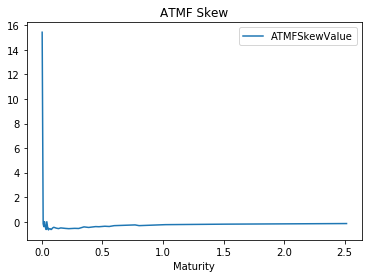

In [66]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
ATMF_Skew_Market = ATMFSkew_Market.set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
ATMF_Skew_Market.plot(title = 'ATMF Skew')

Malheureusement, malgré le travail effectué, le graphe du Skew ATMF n'est pas cohérent et ne peut donc être utilisé pour la calibration. Il en est de même pour celui de la Volatilité de la Volatilité des Variance Swaps sur S&P500, artificiellement créée du fait de l'absence de donnée concernant les Variance Swaps.

Cependant, Il a été possible de trouver des données concernant ces deux quantités dans les travaux de l'étudiant M. Fei Wang de l'Imperial College London, pour une cotation datant du 16 Avril 2016. Il convient donc d'utiliser ces données, à défaut d'obtenir celles provenant de la cotation actuelle.

### Utilisation de données alternatives provenant de la cotation du 16 Avril 2016

De ce fait, les données de la volatilité de volatilité des variances swaps $Vol(\hat{\sigma}_0^t)$ et du Skew ATMF $S_t^{Mkt}$ sont créées :

In [67]:
# Création de la Vol de Vol du marché
Maturity_Vol = [0.125, 0.175, 0.25, 0.50, 0.75, 1, 1.25, 1.50, 2]
n = len(Maturity_Vol)

Index = [i for i in range(n)]
MarketVolofVol = pd.DataFrame(index = Index)

MarketVolofVol['Maturity'] = Maturity_Vol
MarketVolofVol['VolVSVol'] = [120/100, 89.14/100, 72.74/100, 52.74/100, 45.86/100, 40/100, 36.36/100, 32.72/100,29.08/100]

# Création du Skew ATMF du Marché
Maturity_ATMF = [0.099,0.165,0.231,0.33,0.429,0.665,0.764,0.90,1.165,1.665,2.665]
m = len(Maturity_ATMF)

Index = [i for i in range(m)]
MarketATMFSkew = pd.DataFrame(index = Index)

MarketATMFSkew['Maturity'] = Maturity_ATMF
MarketATMFSkew['ATMFSkew'] = [1.516/100, 1.456/100, 1.4/100, 1.256/100, 1.2/100, 0.925/100, 0.856/100, 0.772/100, 0.684/100, 0.544/100, 0.4/100]

En traçant le graphe de ces deux quantités, nous obtenons :

Text(0, 0.5, 'ATMF Skew')

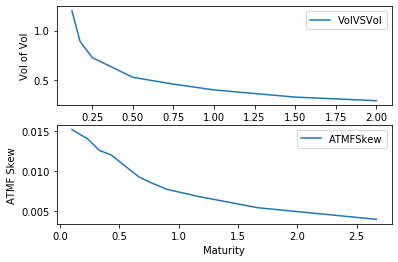

In [68]:
Market_VolofVol = MarketVolofVol.set_index('Maturity').sort_index()
Market_ATMFSkew = MarketATMFSkew.set_index('Maturity').sort_index()

fig, ax = plt.subplots(2,1)
plt1 = Market_VolofVol.plot(ax=ax[0])
plt1.set_xlabel('Maturity')
plt1.set_ylabel('Vol of Vol')

plt2 = Market_ATMFSkew.plot(ax=ax[1])
plt2.set_xlabel('Maturity')
plt2.set_ylabel('ATMF Skew')

Malheureusement les données brutes concernant la structure à terme des Swaps de Variance sur S&P500 n'ont pas été fournies pour la date du 16 Avril 2016. Cependant, en prenant une paramétrisation mean-reverting pour spécifier cette structure, c'est à dire en considérant que :

$$
\hat{\sigma}_0^t = z_1 + (z_2 - z_1)e^{-z_3t}
$$

La calibration qui a été faite par M. Fei Wang a pu permettre d'obtenir les paramètres : 

$$
z_1 = 12.03\%, z_2 = 21.80\%, z_3 = 2.166
$$

Sachant que la variance forward instantanée initiale $\xi_0^t$ est donnée à partir l'expression du prix du Variance Swap paramétrisé selon le schema mean-reverting, donné par :

$$
\hat{\sigma}_0^t = z_2 + (z_1 - z_2)e^{-z_3t} = \sqrt{\frac{1}{t}\int_0^t \xi_0^udu}
$$

et donc que l'expression de $\xi_0^t$ est donnée par :

$$
\xi_0^t = (z_2 + (z_1-z_2)e^{-z_3t})^2 -2tz_3(z_1-z_2)e^{-z_3t}(z_2 + (z_1-z_2)e^{-z_3t})
$$

avec ici $z_1 = 12.03\%$, $z_2 = 21.80\%$ et $z_3 = 2.166$, il est possible d'implémenter la fonction comme suit, tout comme celle du prix des variances swaps :

In [69]:
def ForwardVarInitial(t):
    z1 = 12.03/100
    z2 = 21.80/100
    z3 = 2.166
    return (z2 + (z1-z2)*math.exp(-z3*t))**2 - 2*t*z3*(z1-z2)*math.exp(-z3*t)*(z2 + (z1-z2)*math.exp(-z3*t))

def VarianceSwapPrice(t):
    z1 = 12.03/100
    z2 = 21.80/100
    z3 = 2.166
    return z2 + (z1-z2)*math.exp(-z3*t)

La visualisation graphique des deux fonctions donne :

Text(0, 0.5, 'Initial Variance Forward')

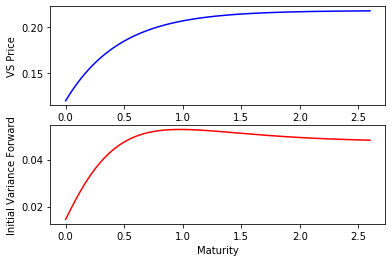

In [70]:
# On définit un dataframe contenant la Vol de Vol et le Skew ATMF sous le modèle de Bergomi
Maturity = np.linspace(0.001,2.6,1000)
VSPrice = [VarianceSwapPrice(t) for t in Maturity]
InitialVarianceForward = [ForwardVarInitial(t) for t in Maturity]

fig, ax = plt.subplots(2,1)

ax[0].plot(Maturity,VSPrice , color = 'b', label = 'Variance Swap Price')
ax[0].set_xlabel('Maturity')
ax[0].set_ylabel('VS Price')

ax[1].plot(Maturity,InitialVarianceForward, color = 'r', label = 'Initial Variance Forward')
ax[1].set_xlabel('Maturity')
ax[1].set_ylabel('Initial Variance Forward')

### Méthode retenue pour la calibration des paramètres $\Theta = \{\omega, \gamma, k_1, k_2, \rho_1, \rho_2, \rho_{12} \}$

Une approche aurait été d'effectuer une calibration séparée, c'est à dire de :

- Calibrer $\omega, \gamma, k_1, k_2, \rho_{12}$ via le problème de minimisation : $argmin_{\Theta}\sum_T (\nu_0^T - Vol(\hat{\sigma}_0^{T}))^2$
- Et ensuite calibrer $\rho_1, \rho_2$ via le problème $argmin_{\rho_1, \rho_2}\sum_T (S_T^{order \ 1} - S_T^{mkt} )^2$

Cependant, il a été montré dans la littérature que celle ci de permettait pas de capturer précisément le skew de volatilité implicite du marché. Ainsi, il a été décidé de calibrer conjointement l'ensemble des paramètres $\Theta = \{\omega, \gamma, k_1, k_2, \rho_1, \rho_2, \rho_{12} \}$ via le problème de minimisation suivante :

$$
\Theta_{opt} = argmin_{\Theta}(\theta_1 \sum_T (\frac{\nu_0^T - Vol(\hat{\sigma}_0^{T})}{Vol(\hat{\sigma}_0^{T})})^2 + \theta_2 \sum_\hat{T} (\frac{S_\hat{T}^{order \ 1} - S_\hat{T}^{mkt}}{S_\hat{T}^{mkt}})^2)
$$

où $\theta_1 = 0.05$ et $\theta_2 = 0.95$. En effet, il est bien plus important que ce soit le Skew ATMF des options sur S&P500 qui soit bien calibré, par rapport à la volatilité du prix des Variance Swaps. C'est pourquoi le poids attribué au premier est bien plus important que celui de la dernière.

Sachant que les données de marchés ont été construites précédemment et que les expressions théoriques de la volatilité de volatilité $\nu_0^T$ et du Skew ATMF $S_\hat{T}^{order \ 1}$ sous le modèle de Bergomi à deux facteurs sont données par :

$$
\nu_0^T = \frac{\omega \alpha_{\gamma}}{2} \sqrt{(1 - \gamma)^2 A_1^2 + \gamma^2 A_2^2 + 2\rho_{12}\gamma (1-\gamma)A_1 A_2}
$$

avec une fois de plus $\alpha_{\gamma} = 1/\sqrt{(1-\gamma)^2 + \gamma^2 + 2\rho_{12}\gamma (1-\gamma)} et pour $i = 1,2$ : $A_i = \frac{\int_0^T\xi_0^u e^{-k_i u} du}{\int_0^T\xi_0^u du} = \frac{1- e^{-k_iT}}{k_iT}$ dans le cas d'une structure à terme 'flat' des variances forward ou des volatilités de Variance Swap, et

$$
S_T^{order \ 1} = \frac{\omega \alpha_{\gamma}}{2(\hat{\sigma}^T)^3T^2} \int_0^Tdt \sqrt{\xi_0^t} \int_t^T\xi_0^u[(1-\gamma)\rho_1e^{-k_1(u-t)} + \gamma \rho_2 e^{-k_1(u-t)}]du
$$

avec $\hat{\sigma}^T = \sqrt{\frac{1}{T}\int_0^T \xi_0^t dt}$. Et dans le cas d'une structure à terme 'flat' :

$$
S_T^{order \ 1} =\frac{\omega \alpha_{\gamma}}{2}[(1-\gamma)\rho_1\frac{k_1T - (1-e^{-k_1T})}{(k_1T)^2} + \gamma \rho_2\frac{k_2T - (1-e^{-k_2T})}{(k_2T)^2}]
$$

Les expressions de la Volatilité de la Volatilité des variance swaps ainsi que du Skew ATMF peuvent donc être implémentés dans le cas général tout comme dans le cas d'une structure à terme plate des variances swaps.

In [71]:
import scipy.integrate as integrate

def BergomiVolOfVSVol(omega,gamma,k1,k2,rho12,T):
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    # Definition de la fonction à intégrer, numérateur de A1 et A2 :
    def FunToIntegrate1(t):
        return ForwardVarInitial(t)*math.exp(-k1*t)
    def FunToIntegrate2(t):
        return ForwardVarInitial(t)*math.exp(-k2*t)
    
    # Calcul de A1, A2, puis de la valeur finale de la Vol de Vol
    A1 = integrate.quad(FunToIntegrate1,0,T)[0]/(T*(VarianceSwapPrice(T)**2))
    A2 = integrate.quad(FunToIntegrate2,0,T)[0]/(T*(VarianceSwapPrice(T)**2))
    value = (omega*alpha_gamma/2)*math.sqrt(((1-gamma)**2)*(A1**2) + (gamma**2)*(A2**2) + 2*rho12*gamma*(1-gamma)*A1*A2)
    return value

def BergomiATMFSkew(omega,gamma,k1,k2,rho1,rho2,rho12,T) :
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    # Definition de la fonction à deux variables pour la double intégrale à calculer :
    def f(u,t):
        return math.sqrt(ForwardVarInitial(t))*ForwardVarInitial(u)*((1-gamma)*rho1*math.exp(-k1*(u-t))+gamma*rho2*math.exp(-k2*(u-t)))

    # Définition des bords d'intégrations :
    def bounds_t():
        return [0,T]
    def bounds_u(t):
        return [t,T]
    
    # Intégration et valeur finale
    value = ((omega*alpha_gamma)/(2*(VarianceSwapPrice(T)**3)*(T**2)))*integrate.nquad(f, [bounds_u, bounds_t])[0]
    return value

def FlatBergomiVolOfVSVol(omega,gamma,k1,k2,rho12,T):
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    A1 = (1-math.exp(-k1*T))/(k1*T)
    A2 = (1-math.exp(-k2*T))/(k2*T)
    value = (omega*alpha_gamma/2)*math.sqrt(max(((1-gamma)**2)*(A1**2) + (gamma**2)*(A2**2) + 2*rho12*gamma*(1-gamma)*A1*A2,0))
    return value

def FlatBergomiATMFSkew(omega,gamma,k1,k2,rho1,rho2,rho12,T) :
    alpha_gamma = 1/math.sqrt((1-gamma)**2+2*rho12*gamma*(1-gamma)+gamma**2)
    B1 = (k1*T - (1-math.exp(-k1*T)))/((k1*T)**2)
    B2 = (k2*T - (1-math.exp(-k2*T)))/((k2*T)**2)
    value = ((omega*alpha_gamma)/2)*((1-gamma)*rho1*B1 + gamma*rho2*B2)
    return value

De ce fait, la fonction à minimiser pour calibrer les paramètres du modèle de Bergomi à deux facteurs est implémentée comme suit :

In [72]:
def BergomiOLSCalibration(*params):
    omega,gamma,k1,k2,rho1,rho2,rho12 = params
    n = len(MarketVolofVol)
    T1 = MarketVolofVol["Maturity"].unique()
    MarketVolVSvol = MarketVolofVol['VolVSVol']
    BergomiVolOfVSVol_list =[0 for i in range(n)]
    for i in range(n):
        BergomiVolOfVSVol_list[i] = BergomiVolOfVSVol(omega,gamma,k1,k2,rho12,T1[i])
    residualsVolofVol = np.power((BergomiVolOfVSVol_list - MarketVolVSvol)/MarketVolVSvol,2)
    
    m = len(MarketATMFSkew)
    T2 = MarketATMFSkew["Maturity"].unique()
    MarketATMFSkewValue = MarketATMFSkew['ATMFSkew']
    BergomiATMFSkew_list =[0 for i in range(m)]
    for i in range(m):
        BergomiATMFSkew_list[i] = BergomiATMFSkew(omega,gamma,k1,k2,rho1,rho2,rho12,T2[i])
    residualsATMFSkew = np.power((BergomiATMFSkew_list - MarketATMFSkewValue)/MarketATMFSkewValue,2)
    
    theta1 = 0.05
    theta2 = 0.95
    OLS = theta1*np.sum(residualsVolofVol) + theta2*np.sum(residualsATMFSkew)
    return OLS

Ainsi, la calibration peut être effectuée, en considérant l'ensemble de définition de chaque paramètres à calibrer. Il convient de se rappeler particulièrement que :

- le coefficient de corrélation entre les deux processus d'Ornstein Uhlenbeck $\rho_{12}$ est positif, entre 0 et 1
- les coefficients $\rho_1$ et $\rho_2$ de corrélation entre ces deux processus, définissant la courbe de variance forward, et le prix du sous-jacent $S$, sont négatifs, compris entre -1 et 0
- le paramètre $\gamma$ illustrant le "poids" des deux doit être compris entre 0 et 1, bords exclus
- $\omega$ est en général proche de 2, et compris entre 1 et 4
- $k_1$ et $k_2$ prennent en général des valeurs très éloignées entre elles. De ce fait, il seront compris entre 0.05 et 1 pour l'un, et entre 2 et 10 pour l'autre.

In [73]:
optimize_function = lambda params :  BergomiOLSCalibration(*params)

# On définit les conditions aux bords pour chaque variable :
bound_omega = (1, 10)
bound_gamma = (0.1, 0.9)
bound_k1 = (3,20)
bound_k2 = (0.05,3)
bound_rho1 = (-1, -0.01)
bound_rho2 = (-1, -0.01)
bound_rho12 = (0.01, 1)
general_bounds = (bound_omega,bound_gamma,bound_k1,bound_k2,bound_rho1,bound_rho2,bound_rho12)

# On définit les paramètres initiaux
param_initiaux = [3,0.5,5,1,-0.9,-0.9,0.7]

CalibratedBergomiParam = spop.minimize(optimize_function,param_initiaux,method='SLSQP',bounds = general_bounds)

In [74]:
optimize_function = lambda params :  BergomiOLSCalibration(*params)
param_initiaux = [3,0.5,9,0.2,-0.5,-0.5,0.2]
CalibratedBergomiParam = spop.fmin(optimize_function,param_initiaux, maxiter = 1400, maxfun = 1400)

Optimization terminated successfully.
         Current function value: 0.484975
         Iterations: 874
         Function evaluations: 1367


In [75]:
(omega,gamma,k1,k2,rho1,rho2,rho12) = CalibratedBergomiParam
print("les paramètres calibrés du modèle de Bergomi sont : omega = %f, gamma = %f, k1 = %f, k2 = %f, rho1 = %f, rho2 = %f, rho12 = %f" % (omega,gamma,k1,k2,rho1,rho2,rho12))

les paramètres calibrés du modèle de Bergomi sont : omega = -0.102929, gamma = 0.183856, k1 = 4.753159, k2 = 0.665388, rho1 = -0.579564, rho2 = -0.520758, rho12 = 0.103420


Le résultat de la calibration donne donc les paramètres suivants :

$$
\omega = -0.102929, \gamma = 0.183856, k_1 = 4.753159, k_2 = 0.665388, \rho_1 = -0.579564, \rho_2 = -0.520758, \rho_{12} = 0.103420
$$

Il est donc possible de constater que malgré un $\omega$ négatif, qui n'a pas d'incidence sur la dynamique de la variance forward instantanée grâce à la propriété de symétrie des mouvements browniens, l'ensemble des paramètres sont cohérents avec les résultats théoriques concernant leur ensemble de définition.

### Vérification de la qualité de la calibration

La calibration ayant été effectuée, il convient de comparer les structures à terme du marché et calculé par le modèle de Bergomi à deux facteurs, de la volatilité de volatilité de Variance Swap et celui du Skew ATMF:

Text(0, 0.5, 'ATMFSkew')

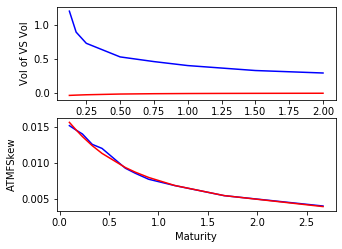

In [76]:
# On définit un dataframe contenant la Vol de Vol et le Skew ATMF sous le modèle de Bergomi
Bergomi_VolVSVol = [BergomiVolOfVSVol(omega,gamma,k1,k2,rho12,t) for t in Maturity_Vol]
Bergomi_ATMFSkew = [BergomiATMFSkew(omega,gamma,k1,k2,rho1,rho2,rho12,t) for t in Maturity_ATMF]

fig, ax = plt.subplots(2,1, figsize=(5, 3.75))

ax[0].plot(Maturity_Vol,MarketVolofVol['VolVSVol'], color = 'b', label = 'Market Vol of VS Vol')
ax[0].plot(Maturity_Vol,Bergomi_VolVSVol, color = 'r', label = 'Bergomi Vol of VS Vol')
ax[0].set_xlabel('Maturity')
ax[0].set_ylabel('Vol of VS Vol')

ax[1].plot(Maturity_ATMF,MarketATMFSkew['ATMFSkew'], color = 'b', label = 'Market Vol of VS Vol')
ax[1].plot(Maturity_ATMF,Bergomi_ATMFSkew, color = 'r', label = 'Bergomi Vol of VS Vol')
ax[1].set_xlabel('Maturity')
ax[1].set_ylabel('ATMFSkew')


Si le Skew ATMF est très bien calibré, ce qui est la priorité première dans le cas de la calibration pour la valorisation des options sur S&P500 sous le modèle de Bergomi (poids de 0.95 pour calibrer le Skew ATMF), il n'en est aucunement le cas pour la Volatilité de la Volatilité de variance swap sur S&P500 malheureusement. Plus particulièrement, lorsque l'on effectue une calibration des paramètres de Bergomi uniquement sur cette quantité, il est possible de constater des valeurs très élevée voire aberrante, témoignant soit des erreurs de données qui sont trop élevées, soit des erreurs dans l'implémentation de la fonction retournant cette quantité sous le modèle de Bergomi à deux facteurs. Il convient ainsi de se focaliser sur ces deux points pour régler le problème.

# Bibliographie

- Lorenzo Bergomi, *Smile Dynamic II*, (2005)
- Fei Wang, *Forward Variance Dynamics: Bergomi Model And Its Applications In Pricing Cliquet Options*, Imperial College London (2017)
- J. Gatheral and  A. Jacquier, *Arbitrage-free SVI volatility surfaces*, Quantitative Finance, 14 (2014)
- B. Horvath, A. Jacquier, and P. Tankov, *Volatility options in rough volatility models*
- F.D. Rouah, *Variance Swap Pricing*